In [11]:
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import pandas as pd

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

### 버스, 따릉이, 지하철 데이터 로드 및 좌표 변환

# 교통 지수

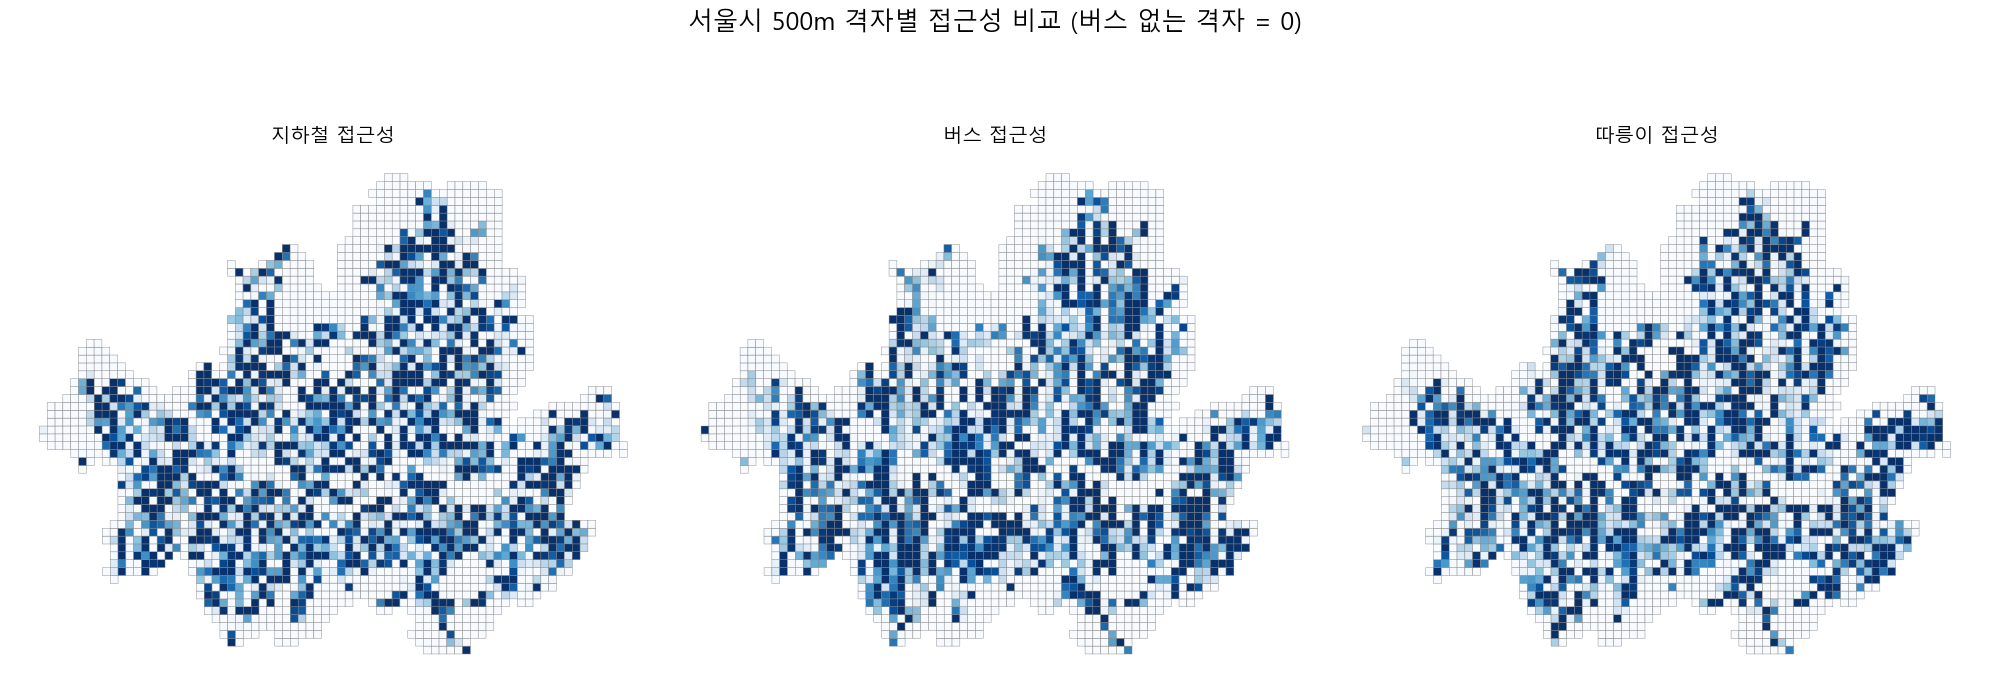

In [12]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt


geo_shp_wgs84 = gpd.read_file("seoul_grid_500m.shp")
geo_shp = geo_shp_wgs84.to_crs("EPSG:5179")
seoul_wgs84 = gpd.read_file("서울시 상권분석서비스(영역-행정동).shp"
)
seoul = seoul_wgs84.to_crs("EPSG:5179")

def compute_buffer_ratio(geo_points, buffer_radius=1000):
    """점 데이터를 기준으로 버퍼를 만들고, 격자별 커버율 계산"""
    buffers = gpd.GeoDataFrame(geometry=geo_points.buffer(buffer_radius), crs=geo_shp.crs)
    intersect = gpd.overlay(geo_shp, buffers, how="intersection")
    intersect["area"] = intersect.geometry.area
    area_sum = intersect.groupby(intersect.index)["area"].sum()
    ratio = area_sum / geo_shp.geometry.area
    return ratio.fillna(0)

# 지하철
df_metro = pd.read_csv("서울시 역사마스터 정보.csv", encoding="cp949")
df_metro = df_metro.rename(columns={"X좌표": "경도", "Y좌표": "위도"})
df_metro["geometry"] = df_metro.apply(lambda x: Point(x["경도"], x["위도"]), axis=1)
geo_metro = gpd.GeoDataFrame(df_metro, crs="EPSG:4326", geometry="geometry").to_crs("EPSG:5179")
geo_metro = gpd.sjoin(geo_metro, seoul, predicate="within").drop(columns=["index_right"])
geo_shp["metro_ratio"] = compute_buffer_ratio(geo_metro)

# 버스정류장
df_bus = pd.read_csv("서울시 버스정류소 위치정보.csv", encoding="cp949")
df_bus = df_bus.rename(columns={"X좌표": "경도", "Y좌표": "위도"})
df_bus["geometry"] = df_bus.apply(lambda x: Point(x["경도"], x["위도"]), axis=1)
geo_bus = gpd.GeoDataFrame(df_bus, crs="EPSG:4326", geometry="geometry").to_crs("EPSG:5179")
geo_bus = gpd.sjoin(geo_bus, seoul, predicate="within").drop(columns=["index_right"])
geo_shp["bus_ratio"] = compute_buffer_ratio(geo_bus)

# 따릉이
df_bic = pd.read_csv("서울시 따릉이대여소 마스터 정보.csv", encoding="cp949")
df_bic = df_bic.rename(columns={"X좌표": "경도", "Y좌표": "위도"})
df_bic["geometry"] = df_bic.apply(lambda x: Point(x["경도"], x["위도"]), axis=1)
geo_bic = gpd.GeoDataFrame(df_bic, crs="EPSG:4326", geometry="geometry").to_crs("EPSG:5179")
geo_bic = gpd.sjoin(geo_bic, seoul, predicate="within").drop(columns=["index_right"])
geo_shp["bic_ratio"] = compute_buffer_ratio(geo_bic)

# ──────────────────────────────
#  버스 없는 격자 식별 후 → 전부 0으로
# ──────────────────────────────
# 버스가 존재하는 격자 찾기
bus_join = gpd.sjoin(geo_shp, geo_bus, predicate="contains", how="left")
bus_presence = bus_join.groupby(bus_join.index)["index_right"].count()
# 버스 없는 격자 인덱스 추출
no_bus_idx = bus_presence[bus_presence == 0].index
# 버스가 없는 곳은 전부 0으로 강제 설정
geo_shp.loc[no_bus_idx, ["bus_ratio", "metro_ratio", "bic_ratio"]] = 0


geo_shp = geo_shp.to_crs("EPSG:4326")

fig, axes = plt.subplots(1, 3, figsize=(20, 8))
cols = ["metro_ratio", "bus_ratio", "bic_ratio"]
titles = ["지하철 접근성", "버스 접근성", "따릉이 접근성"]

for i, ax in enumerate(axes):
    geo_shp.plot(ax=ax, column=cols[i], cmap="Blues", legend=False, edgecolor="gray", linewidth=0.3)
    ax.set_title(titles[i], fontsize=14)
    ax.set_axis_off()

plt.suptitle("서울시 500m 격자별 접근성 비교 (버스 없는 격자 = 0)", fontsize=18)
plt.tight_layout()
plt.show()


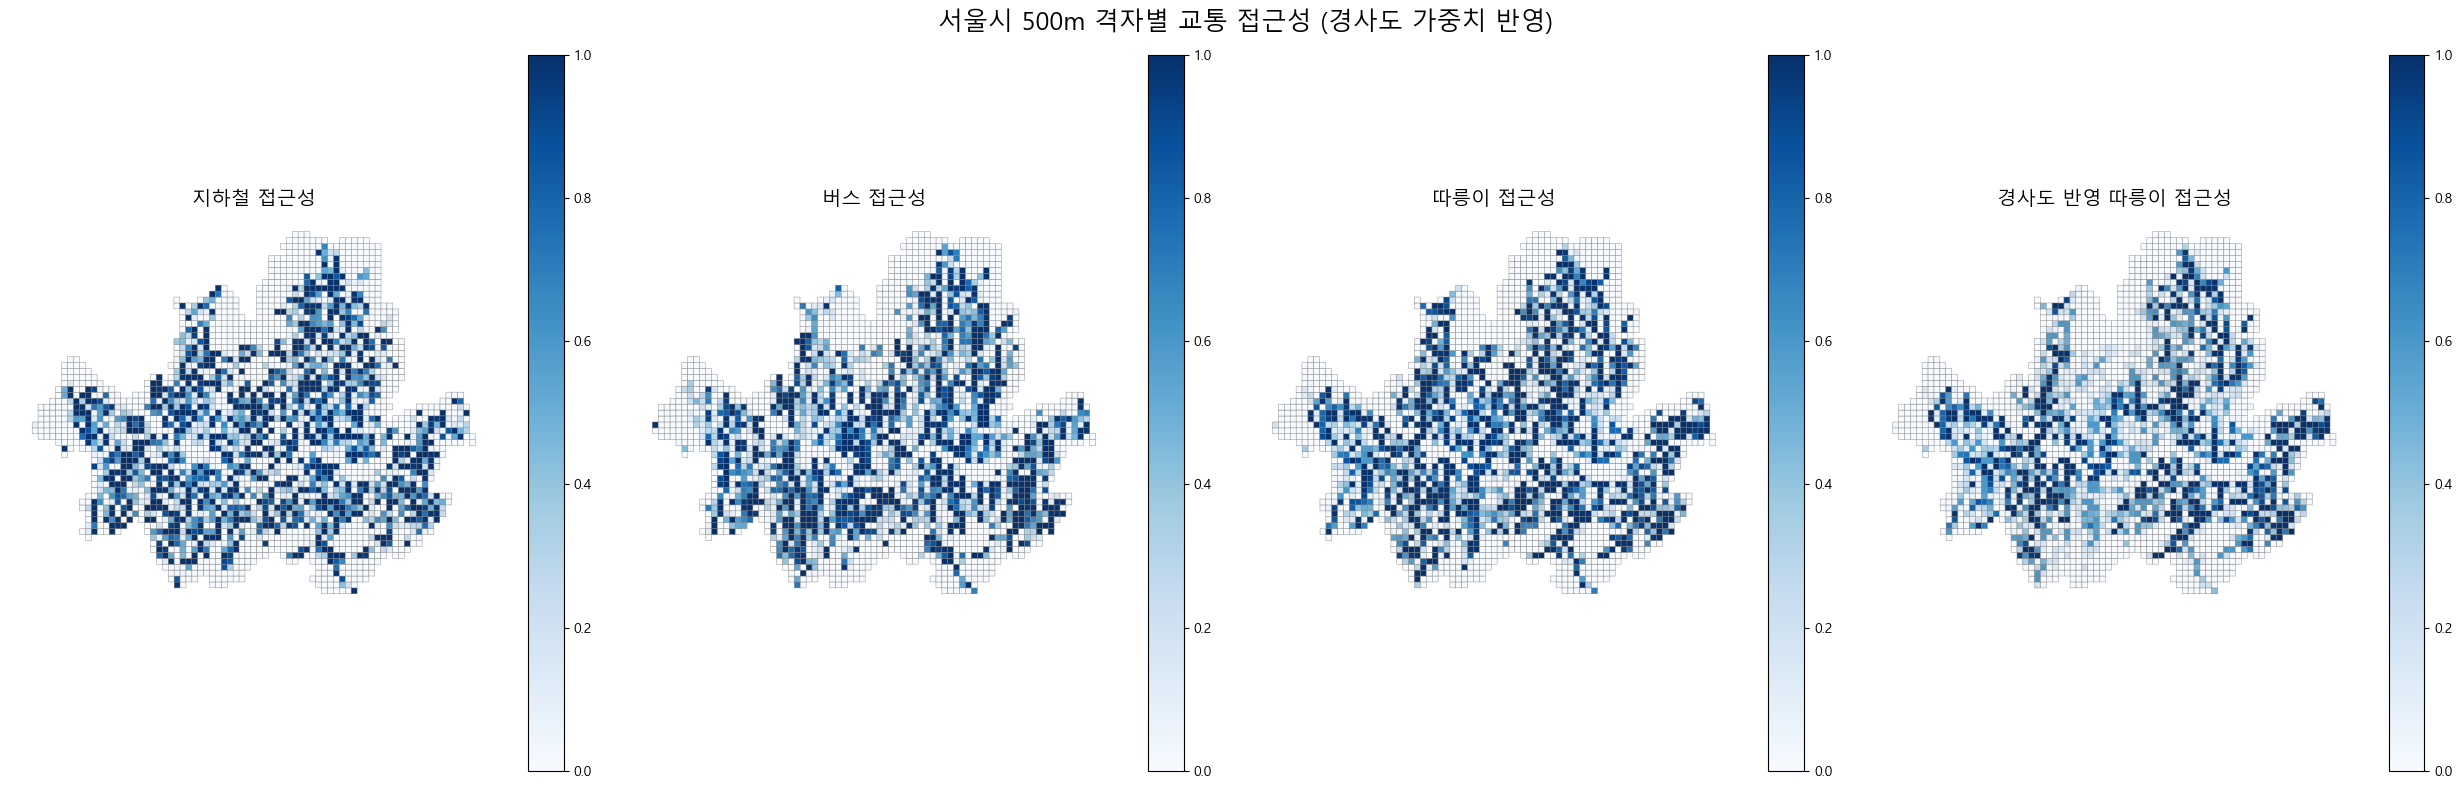

In [13]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np

geo_shp_wgs84 = gpd.read_file("seoul_grid_500m.shp")
geo_shp = geo_shp_wgs84.to_crs("EPSG:5179")
seoul_wgs84 = gpd.read_file("서울시 상권분석서비스(영역-행정동).shp")
seoul = seoul_wgs84.to_crs("EPSG:5179")

def compute_buffer_ratio(geo_points, buffer_radius=1000):
    """점 데이터를 기준으로 버퍼를 만들고, 격자별 커버율 계산"""
    buffers = gpd.GeoDataFrame(geometry=geo_points.buffer(buffer_radius), crs=geo_shp.crs)
    intersect = gpd.overlay(geo_shp, buffers, how="intersection")
    intersect["area"] = intersect.geometry.area
    area_sum = intersect.groupby(intersect.index)["area"].sum()
    ratio = area_sum / geo_shp.geometry.area
    return ratio.fillna(0)

# 지하철
df_metro = pd.read_csv("서울시 역사마스터 정보.csv", encoding="cp949")
df_metro = df_metro.rename(columns={"X좌표": "경도", "Y좌표": "위도"})
df_metro["geometry"] = df_metro.apply(lambda x: Point(x["경도"], x["위도"]), axis=1)
geo_metro = gpd.GeoDataFrame(df_metro, crs="EPSG:4326", geometry="geometry").to_crs("EPSG:5179")
geo_metro = gpd.sjoin(geo_metro, seoul, predicate="within").drop(columns=["index_right"])
geo_shp["metro_ratio"] = compute_buffer_ratio(geo_metro)

# 버스정류장
df_bus = pd.read_csv("서울시 버스정류소 위치정보.csv", encoding="cp949")
df_bus = df_bus.rename(columns={"X좌표": "경도", "Y좌표": "위도"})
df_bus["geometry"] = df_bus.apply(lambda x: Point(x["경도"], x["위도"]), axis=1)
geo_bus = gpd.GeoDataFrame(df_bus, crs="EPSG:4326", geometry="geometry").to_crs("EPSG:5179")
geo_bus = gpd.sjoin(geo_bus, seoul, predicate="within").drop(columns=["index_right"])
geo_shp["bus_ratio"] = compute_buffer_ratio(geo_bus)

# 따릉이
df_bic = pd.read_csv("서울시 따릉이대여소 마스터 정보.csv", encoding="cp949")
df_bic = df_bic.rename(columns={"X좌표": "경도", "Y좌표": "위도"})
df_bic["geometry"] = df_bic.apply(lambda x: Point(x["경도"], x["위도"]), axis=1)
geo_bic = gpd.GeoDataFrame(df_bic, crs="EPSG:4326", geometry="geometry").to_crs("EPSG:5179")
geo_bic = gpd.sjoin(geo_bic, seoul, predicate="within").drop(columns=["index_right"])
geo_shp["bic_ratio"] = compute_buffer_ratio(geo_bic)

# ──────────────────────────────
# 버스 없는 격자 → 접근성 0
# ──────────────────────────────
bus_join = gpd.sjoin(geo_shp, geo_bus, predicate="contains", how="left")
bus_presence = bus_join.groupby(bus_join.index)["index_right"].count()
no_bus_idx = bus_presence[bus_presence == 0].index
geo_shp.loc[no_bus_idx, ["bus_ratio", "metro_ratio", "bic_ratio"]] = 0

# ──────────────────────────────
# 경사도 가중치 반영
# ──────────────────────────────
slope_shp = gpd.read_file("slope_seoul.shp").to_crs("EPSG:5179")

geo_shp = geo_shp.merge(
    slope_shp.drop(columns="geometry"),
    left_index=True,
    right_index=True,
    how="left"
)

conditions = [
    (geo_shp["slope_mean"] <= 3),     # 평지
    (geo_shp["slope_mean"] > 3) & (geo_shp["slope_mean"] <= 7),  # 완경사
    (geo_shp["slope_mean"] > 7)       # 급경사
]
weights = [1.0, 0.6, 0.2]

geo_shp["slope_weight"] = np.select(conditions, weights, default=0)
geo_shp["bic_ratio_weighted"] = geo_shp["bic_ratio"] * geo_shp["slope_weight"]



geo_shp = geo_shp.to_crs("EPSG:4326")

fig, axes = plt.subplots(1, 4, figsize=(25, 8))
cols = ["metro_ratio", "bus_ratio", "bic_ratio", "bic_ratio_weighted"]
titles = ["지하철 접근성", "버스 접근성", "따릉이 접근성", "경사도 반영 따릉이 접근성"]

for i, ax in enumerate(axes):
    geo_shp.plot(ax=ax, column=cols[i], cmap="Blues", legend=True, edgecolor="gray", linewidth=0.3)
    ax.set_title(titles[i], fontsize=14)
    ax.set_axis_off()

plt.suptitle("서울시 500m 격자별 교통 접근성 (경사도 가중치 반영)", fontsize=18)
plt.tight_layout()
plt.savefig('서울시 500m 격자별 교통 접근성 (경사도 가중치 반영).png')
plt.show()

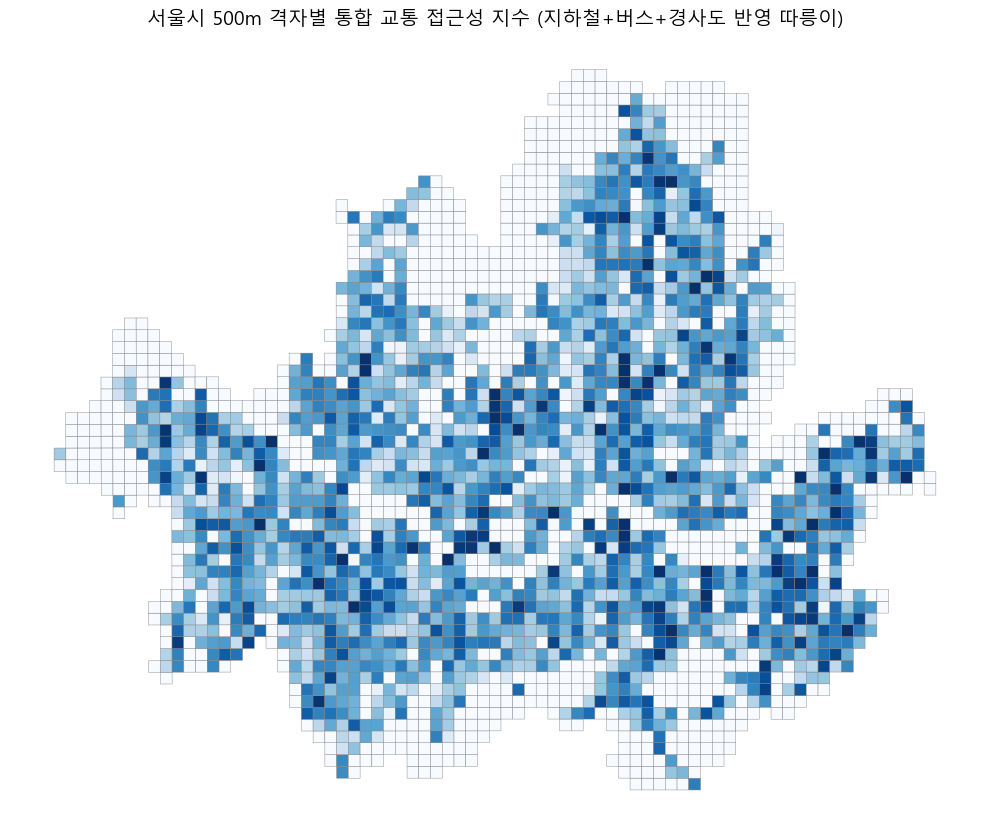

In [14]:
geo_shp["total_access"] = (
    geo_shp["metro_ratio"] +
    geo_shp["bus_ratio"] +
    geo_shp["bic_ratio_weighted"]
)

# 필요하면 정규화 (0~1 구간)
# geo_shp["total_access"] = (
#     (geo_shp["total_access"] - geo_shp["total_access"].min()) /
#     (geo_shp["total_access"].max() - geo_shp["total_access"].min())
# )

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
geo_shp.plot(
    ax=ax,
    column="total_access",
    cmap="Blues",
    legend=False,
    edgecolor="gray",
    linewidth=0.3
)

ax.set_title("서울시 500m 격자별 통합 교통 접근성 지수 (지하철+버스+경사도 반영 따릉이)", fontsize=14)
ax.set_axis_off()

plt.tight_layout()
plt.savefig('서울시 500m 격자별 교통 접근성 (지하철+버스+경사도 반영 따릉이).png')

plt.show()

# 상권 지수

In [15]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. 파일 읽기 및 결측치 처리
df = pd.read_csv('상권지수(데이터누락).csv', encoding='cp949')
df.replace('-', 0, inplace=True)

# 2. [수정] 계산에 사용할 모든 열을 숫자(numeric) 타입으로 변경
cols_to_numeric = ['20분이상방문자수', '2023유입인구수', '이용금액']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# 3. [수정] 모든 변수를 0~1 사이의 값으로 '정규화(Normalization)' 통일
scaler = MinMaxScaler()

# '20분이상방문자수'는 0을 제외하고 정규화
not_zero = df['20분이상방문자수'] != 0
df_not_zero = df[not_zero].copy()
if not df_not_zero.empty:
    df_not_zero['정규화된_방문자수'] = scaler.fit_transform(df_not_zero[['20분이상방문자수']])
    df = df.merge(df_not_zero[['자치구', '정규화된_방문자수']], on='자치구', how='left')
    df['정규화된_방문자수'].fillna(0, inplace=True)
else:
    df['정규화된_방문자수'] = 0 # 모든 값이 0인 경우

# 나머지 변수들도 동일한 scaler를 사용하여 0~1 사이로 정규화
df['정규화된_2023유입인구수'] = scaler.fit_transform(df[['2023유입인구수']])
df['정규화된_이용금액'] = scaler.fit_transform(df[['이용금액']])

# 4. 정규화로 통일된 변수들을 사용하여 최종 점수 계산
df['최종점수'] = (df['정규화된_방문자수'] + 1) * df['정규화된_2023유입인구수'] + df['정규화된_이용금액']

# 5. 결과 확인
print(df[['자치구', '정규화된_방문자수', '정규화된_2023유입인구수', '정규화된_이용금액', '최종점수']])

     자치구  정규화된_방문자수  정규화된_2023유입인구수  정규화된_이용금액      최종점수
0    강남구   0.579181        0.791176   1.000000  2.249410
1    강동구   0.000000        0.282769   0.303212  0.585981
2    강북구   0.012531        0.052513   0.279060  0.332231
3    강서구   0.068714        0.590502   0.186447  0.817526
4    관악구   0.099292        1.000000   0.113566  1.212858
5    광진구   0.000000        0.325450   0.253009  0.578460
6    구로구   0.081421        0.288560   0.098893  0.410948
7    금천구   0.097828        0.048473   0.000000  0.053215
8    노원구   0.003755        0.307437   0.770871  1.079462
9    도봉구   0.064848        0.029797   0.416371  0.448100
10  동대문구   0.000000        0.368084   0.257526  0.625610
11   동작구   0.028473        0.557781   0.058906  0.632568
12   마포구   0.974346        0.636441   0.189355  1.445911
13  서대문구   0.138567        0.414848   0.033300  0.505632
14   서초구   0.521483        0.490827   0.575585  1.322370
15   성동구   0.001896        0.280710   0.232172  0.513414
16   성북구   0.029945        0.50

C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\89867683.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['정규화된_방문자수'].fillna(0, inplace=True)


C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\140198456.py:34: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_in_seoul = grid[grid.intersects(seoul.unary_union)]
C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\140198456.py:43: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  seoul_wgs["centroid"] = seoul_wgs.geometry.centroid
C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\140198456.py:44: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  seoul_wgs["cx"] = seoul_wgs.centroid.x
C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\140198456.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.

<bound method NDFrame.head of                                                   geometry ADSTRD_CD  \
GU_CODE                                                                
11110    POLYGON ((126.96883 37.56798, 126.96866 37.567...  11110515   
11140    POLYGON ((127.00421 37.55015, 127.00419 37.550...  11140520   
11170    POLYGON ((126.9824 37.50653, 126.981 37.50653,...  11170510   
11200    POLYGON ((127.03479 37.53583, 127.03473 37.535...  11200520   
11215    POLYGON ((127.07205 37.52342, 127.07035 37.523...  11215840   
11230    POLYGON ((127.05495 37.56516, 127.05485 37.565...  11230536   
11260    POLYGON ((127.09375 37.57057, 127.09337 37.570...  11260520   
11290    POLYGON ((127.02427 37.57909, 127.02425 37.579...  11290575   
11305    POLYGON ((127.02188 37.61233, 127.02181 37.612...  11305534   
11320    POLYGON ((127.03642 37.63686, 127.03607 37.636...  11320511   
11350    POLYGON ((127.06546 37.6149, 127.06515 37.6148...  11350560   
11380    POLYGON ((126.91277 37.58

C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\140198456.py:155: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  krig_points = krig_points[krig_points.within(seoul_m.unary_union)]


버스 정류장 데이터를 로드하고 좌표계를 통일합니다...
격자 내 버스 정류장 존재 여부를 확인합니다...
총 874개의 격자에 버스 정류장이 없어 값을 0으로 변경합니다.


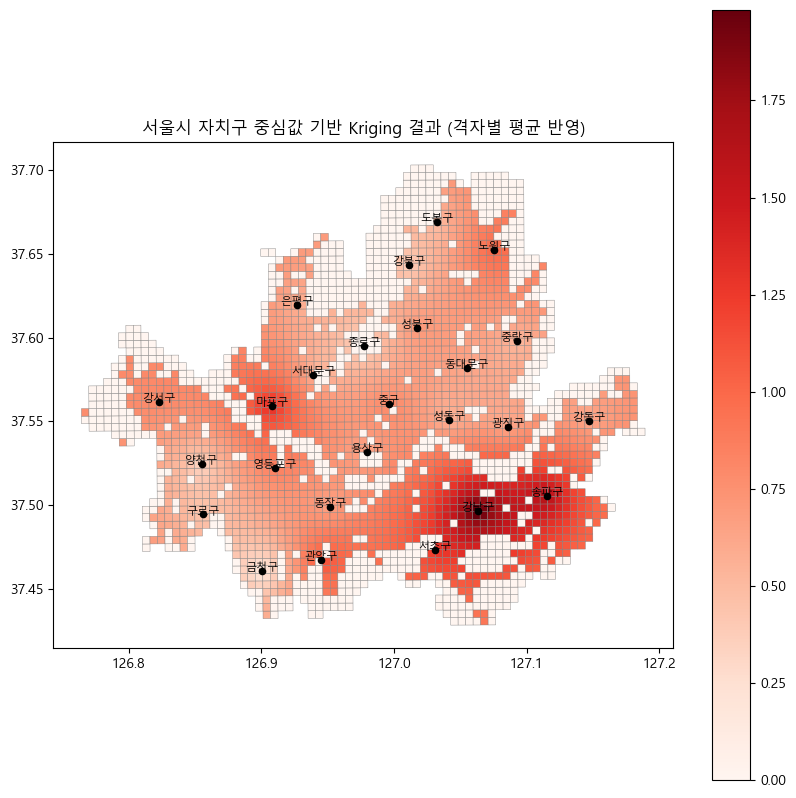

In [16]:
#%%
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy.interpolate import griddata

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
#seoul = gpd.read_file("서울시 상권분석서비스(영역-행정동).shp")

#산, 한강 제거하기
seoul_wgs84 = gpd.read_file("서울시 상권분석서비스(영역-행정동).shp")
seoul = seoul_wgs84.to_crs("EPSG:5179")


minx, miny, maxx, maxy = seoul.total_bounds
res = 500  # 500m
x_coords = np.arange(minx, maxx, res)
y_coords = np.arange(miny, maxy, res)
grid_polys = []
grid_centers = []
for x in x_coords:
    for y in y_coords:
        poly = Polygon([(x,y),(x+res,y),(x+res,y+res),(x,y+res)])
        grid_polys.append(poly)
        grid_centers.append((x+res/2, y+res/2))

grid = gpd.GeoDataFrame(geometry=grid_polys, crs=seoul.crs)
grid["cx"] = [c[0] for c in grid_centers]
grid["cy"] = [c[1] for c in grid_centers]

grid_in_seoul = grid[grid.intersects(seoul.unary_union)]

seoul_wgs = seoul.to_crs(epsg=4326)
grid_wgs = grid_in_seoul.to_crs(epsg=4326)

#grid_wgs.to_file("C:/Users/jeongmin/Downloads/seoul_grid_500m.shp", encoding='utf-8')

seoul_wgs["GU_CODE"] = seoul_wgs["ADSTRD_CD"].astype(str).str[:5]
seoul_wgs = seoul_wgs.dissolve(by="GU_CODE")
seoul_wgs["centroid"] = seoul_wgs.geometry.centroid
seoul_wgs["cx"] = seoul_wgs.centroid.x
seoul_wgs["cy"] = seoul_wgs.centroid.y
print(seoul_wgs.head) # 구 없음 

#%%
################################
#
#
#
# seoul_wgs["value"]에 보간하고 싶은 값이 들어가도록!!!
#
#
#
################################


seoul_wgs["value"] = np.random.randint(0, 100, len(seoul_wgs)) # 이따 바꾸기 
df_gu = seoul_wgs[["cx", "cy", "value"]].reset_index()
gu_name_map = {
    "11110": "종로구",
    "11140": "중구",
    "11170": "용산구",
    "11200": "성동구",
    "11215": "광진구",
    "11230": "동대문구",
    "11260": "중랑구",
    "11290": "성북구",
    "11305": "강북구",
    "11320": "도봉구",
    "11350": "노원구",
    "11380": "은평구",
    "11410": "서대문구",
    "11440": "마포구",
    "11470": "양천구",
    "11500": "강서구",
    "11530": "구로구",
    "11545": "금천구",
    "11560": "영등포구",
    "11590": "동작구",
    "11620": "관악구",
    "11650": "서초구",
    "11680": "강남구",
    "11710": "송파구",
    "11740": "강동구"
}

df_gu["GU_NM"] = df_gu["GU_CODE"].map(gu_name_map)
df_gu = df_gu[["GU_CODE", "GU_NM", "cx", "cy", "value"]]


# 구별 임의값 (예: 0~100 사이)
df.rename(columns={'자치구': 'GU_NM'}, inplace=True)

df_gu_1 = pd.merge(df_gu, df, how = 'left', on = 'GU_NM') 
print(df_gu_1.head())


points_gdf = gpd.GeoDataFrame(
    df_gu_1,
    geometry=gpd.points_from_xy(df_gu.cx, df_gu.cy),
    crs=grid_wgs.crs  # grid_wgs 좌표계와 동일하게 맞춤
)

grid_with_value = gpd.sjoin(
    grid_wgs,          # 왼쪽: 격자
    points_gdf[["GU_NM", "최종점수", "geometry"]],  # 오른쪽: 구 중심점
    how="left",
    predicate="contains"   # 중심점이 폴리곤 안에 있을 때만 매칭
)



# %%
from shapely.geometry import Point
from pykrige.ok import OrdinaryKriging

seoul_m = seoul.to_crs(epsg=5186)
points_m = points_gdf.to_crs(epsg=5186)
grid_m = grid_wgs.to_crs(epsg=5186)

x = points_m.geometry.x.values
y = points_m.geometry.y.values
v = points_m["최종점수"].values

OK = OrdinaryKriging(
    x, y, v,
    variogram_model="exponential",
    variogram_parameters={"sill": 1.0, "range": 8000, "nugget": 0.1},
    verbose=False, enable_plotting=False
)

minx, miny, maxx, maxy = seoul_m.total_bounds
res = 300  # 300m 해상도 보간 (격자보다 조금 더 촘촘하게)
gridx = np.arange(minx, maxx, res)
gridy = np.arange(miny, maxy, res)
z, ss = OK.execute("grid", gridx, gridy)
xx, yy = np.meshgrid(gridx, gridy)
zz = np.array(z)

# ───────────────────────────────
#  Kriging 결과를 포인트 GeoDataFrame으로 변환
# ───────────────────────────────
krig_points = gpd.GeoDataFrame(
    {"최종점수": zz.ravel()},
    geometry=[Point(xy) for xy in zip(xx.ravel(), yy.ravel())],
    crs=seoul_m.crs
)

# ───────────────────────────────
# 격자(grid_wgs)별 평균값 계산
# ───────────────────────────────
krig_points = krig_points[krig_points.within(seoul_m.unary_union)]
joined = gpd.sjoin(krig_points, grid_m, predicate="within")
grid_values = joined.groupby(joined.index_right)["최종점수"].mean()
grid_m["kriging_value"] = grid_values

# --- 버스 정류장이 없는 격자를 0으로 마스킹하는 코드 ---

# 1. 버스 정류장 데이터 로드 및 좌표계 통일
print("버스 정류장 데이터를 로드하고 좌표계를 통일합니다...")
df_bus = pd.read_csv("서울시 버스정류소 위치정보.csv", encoding="cp949")
df_bus = df_bus.rename(columns={"X좌표": "경도", "Y좌표": "위도"})
df_bus["geometry"] = [Point(x, y) for x, y in zip(df_bus["경도"], df_bus["위도"])]
geo_bus = gpd.GeoDataFrame(df_bus, crs="EPSG:4326", geometry="geometry")

# Kriging 격자인 grid_m과 동일한 좌표계로 변환해야 정확한 위치 비교가 가능합니다.
geo_bus_m = geo_bus.to_crs(grid_m.crs)

# 2. 격자(grid_m)와 버스 정류장(geo_bus_m)을 공간 조인(sjoin)
# how='left': 버스정류장이 없는 격자도 결과에 남기기 위함
# predicate='contains': 격자(Polygon)가 버스정류장(Point)을 포함하는지 확인
print("격자 내 버스 정류장 존재 여부를 확인합니다...")
joined_grid_bus = gpd.sjoin(grid_m, geo_bus_m, how="left", predicate="contains")

# 3. 각 격자별로 포함된 버스 정류장 수 계산
# sjoin 결과에서 원본 격자(grid_m)의 인덱스로 그룹화하고,
# 매칭된 버스 정류장의 수('index_right')를 셉니다.
bus_counts_per_grid = joined_grid_bus.groupby(joined_grid_bus.index)['index_right'].count()

# 4. 버스 정류장 수가 0인 격자의 인덱스 찾기
no_bus_indices = bus_counts_per_grid[bus_counts_per_grid == 0].index

# 5. 해당 격자의 'kriging_value'를 0으로 설정
print(f"총 {len(no_bus_indices)}개의 격자에 버스 정류장이 없어 값을 0으로 변경합니다.")
grid_m.loc[no_bus_indices, 'kriging_value'] = 0

# --- 마스킹 코드 종료 ---

grid_plot = grid_m.to_crs(epsg=4326)
points_plot = points_m.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))
grid_plot.plot(ax=ax, column="kriging_value", cmap="Reds", legend=True,
               edgecolor="gray", linewidth=0.3)
points_plot.plot(ax=ax, color="black", markersize=20)
for i, row in points_plot.iterrows():
    plt.text(row.cx, row.cy, row.GU_NM, fontsize=8, ha="center")
plt.title("서울시 자치구 중심값 기반 Kriging 결과 (격자별 평균 반영)")
plt.show()


In [17]:
grid_m_comm = grid_m
grid_m_comm.columns = ['geometry', 'cx', 'cy', 'commercial_value']
comm_list = grid_m_comm['commercial_value'] 

In [18]:
grid_m_comm

,geometry,cx,cy,commercial_value
27,"POLYGON ((179193.794 549917.451, 179693.964 54...",935285.254861,1.950416e+06,0.000000
28,"POLYGON ((179191.133 550417.62, 179691.303 550...",935285.254861,1.950916e+06,0.777972
87,"POLYGON ((179696.624 549419.941, 180196.794 54...",935785.254861,1.949916e+06,0.000000
88,"POLYGON ((179693.964 549920.111, 180194.134 54...",935785.254861,1.950416e+06,0.000000
89,"POLYGON ((179691.303 550420.281, 180191.473 55...",935785.254861,1.950916e+06,0.000000
...,...,...,...,...
4481,"POLYGON ((215704.244 550611.839, 216204.433 55...",971785.254861,1.950916e+06,0.733598
4482,"POLYGON ((215701.583 551112.028, 216201.773 55...",971785.254861,1.951416e+06,0.731604
4483,"POLYGON ((215698.922 551612.218, 216199.112 55...",971785.254861,1.951916e+06,0.732155
4484,"POLYGON ((215696.261 552112.407, 216196.45 552...",971785.254861,1.952416e+06,0.000000


# 수요

In [19]:
delivery = pd.read_csv('DELIVERY_202301_202412.csv', encoding='cp949')
delivery['건당평균금액'] = delivery['결제금액'] / delivery['결제건수']
delivery

df= pd.read_csv('수요지수변수.csv', encoding='cp949')
df['건당평균금액'] = df['결제금액'] / df['결제건수']
df

,연도,자치구,1인가구수,2030우울(%),2030스트레스(%),결제건수,결제금액,건당평균금액
0,2023,강남구,37895,25.3,73.8,3.313809e+06,5.580996e+07,16.841635
1,2023,강동구,25383,15.9,51.7,7.532025e+05,1.011451e+07,13.428670
2,2023,강북구,17250,16.0,61.0,4.600377e+05,6.909810e+06,15.020095
3,2023,강서구,51839,10.8,55.0,1.410072e+06,1.972500e+07,13.988650
4,2023,관악구,99467,22.2,68.9,1.270130e+06,1.707398e+07,13.442706
5,2023,광진구,41399,27.7,70.6,1.130522e+06,1.588681e+07,14.052629
6,2023,구로구,26911,13.1,54.0,7.389177e+05,9.974794e+06,13.499195
7,2023,금천구,25487,9.2,50.5,5.070882e+05,6.694727e+06,13.202294
8,2023,노원구,20673,13.4,71.5,7.146842e+05,1.031832e+07,14.437597
9,2023,도봉구,11372,19.4,55.5,3.252033e+05,4.495787e+06,13.824542


In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# [STEP 1] 원본 데이터로 의미있는 지표를 먼저 계산합니다.
# '1인가구수'가 0일 경우를 대비하여 0으로 나누는 오류를 방지합니다.
df['1인가구당_평균금액'] = df['결제건수'] / df['1인가구수']

# 0으로 나눠서 생긴 무한대(inf) 값을 0으로 안전하게 처리합니다.
df.replace([np.inf, -np.inf], 0, inplace=True)
df['1인가구당_평균금액'].fillna(0, inplace=True) # 혹시 모를 NaN 값도 0으로 처리

# [STEP 2] 스케일링할 모든 변수를 하나의 리스트로 정의합니다.
cols_to_scale = ['2030우울(%)', '2030스트레스(%)', '1인가구당_평균금액']

# [STEP 3] 스케일러 객체를 생성하고, 선택한 열들을 한 번에 0~1 사이로 스케일링합니다.
# 이렇게 하면 모든 변수가 동일한 영향력의 출발선에 서게 됩니다.
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# [STEP 4] 스케일링이 완료된 변수들을 사용하여 최종 점수를 계산합니다.
# 이제 모든 변수가 0~1 사이의 값을 가지므로 공평하게 계산됩니다.
df['최종변수'] = df['2030우울(%)'] * df['2030스트레스(%)'] + df['1인가구당_평균금액']

# 결과 확인
print(df[['2030우울(%)', '2030스트레스(%)', '1인가구당_평균금액', '최종변수']].head())

df = df[-25:]
df

   2030우울(%)  2030스트레스(%)  1인가구당_평균금액      최종변수
0   0.888889     0.991501    0.339702  1.221037
1   0.453704     0.365439    0.082123  0.247925
2   0.458333     0.628895    0.068727  0.356971
3   0.217593     0.458924    0.071100  0.170958
4   0.745370     0.852691    0.006758  0.642329


C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\398726825.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['1인가구당_평균금액'].fillna(0, inplace=True) # 혹시 모를 NaN 값도 0으로 처리


,연도,자치구,1인가구수,2030우울(%),2030스트레스(%),결제건수,결제금액,건당평균금액,1인가구당_평균금액,최종변수
25,2024,강남구,38492,0.703704,0.583569,3.179103e+06,5.217020e+07,16.410353,0.318053,0.728713
26,2024,강동구,26599,0.319444,0.124646,7.150585e+05,9.662439e+06,13.512795,0.069682,0.109499
27,2024,강북구,17218,0.356481,0.912181,4.226974e+05,6.188164e+06,14.639702,0.059280,0.384455
28,2024,강서구,52198,0.550926,1.000000,1.315025e+06,1.855272e+07,14.108263,0.062148,0.613074
29,2024,관악구,100664,0.879630,0.895184,1.132835e+06,1.531606e+07,13.520124,0.000000,0.787430
30,2024,광진구,41886,0.587963,0.920680,1.072834e+06,1.487114e+07,13.861539,0.064021,0.605347
31,2024,구로구,27047,0.370370,0.504249,7.269925e+05,9.580246e+06,13.177916,0.069664,0.256423
32,2024,금천구,26494,0.550926,0.719547,5.253588e+05,6.689217e+06,12.732663,0.038234,0.434651
33,2024,노원구,21006,0.236111,0.376771,6.924451e+05,9.616704e+06,13.888038,0.096795,0.185754
34,2024,도봉구,11915,0.851852,0.603399,3.079050e+05,4.273416e+06,13.879009,0.065040,0.579047


C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\3335142525.py:29: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_in_seoul = grid[grid.intersects(seoul.unary_union)]
C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\3335142525.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  seoul_wgs["centroid"] = seoul_wgs.geometry.centroid
C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\3335142525.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  seoul_wgs["cx"] = seoul_wgs.centroid.x
C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\3335142525.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSer

<bound method NDFrame.head of                                                   geometry ADSTRD_CD  \
GU_CODE                                                                
11110    POLYGON ((126.96883 37.56798, 126.96866 37.567...  11110515   
11140    POLYGON ((127.00421 37.55015, 127.00419 37.550...  11140520   
11170    POLYGON ((126.9824 37.50653, 126.981 37.50653,...  11170510   
11200    POLYGON ((127.03479 37.53583, 127.03473 37.535...  11200520   
11215    POLYGON ((127.07205 37.52342, 127.07035 37.523...  11215840   
11230    POLYGON ((127.05495 37.56516, 127.05485 37.565...  11230536   
11260    POLYGON ((127.09375 37.57057, 127.09337 37.570...  11260520   
11290    POLYGON ((127.02427 37.57909, 127.02425 37.579...  11290575   
11305    POLYGON ((127.02188 37.61233, 127.02181 37.612...  11305534   
11320    POLYGON ((127.03642 37.63686, 127.03607 37.636...  11320511   
11350    POLYGON ((127.06546 37.6149, 127.06515 37.6148...  11350560   
11380    POLYGON ((126.91277 37.58

C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\3335142525.py:150: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  krig_points = krig_points[krig_points.within(seoul_m.unary_union)]


버스 정류장 데이터를 로드하고 좌표계를 통일합니다...
격자 내 버스 정류장 존재 여부를 확인합니다...
총 872개의 격자에 버스 정류장이 없어 값을 0으로 변경합니다.


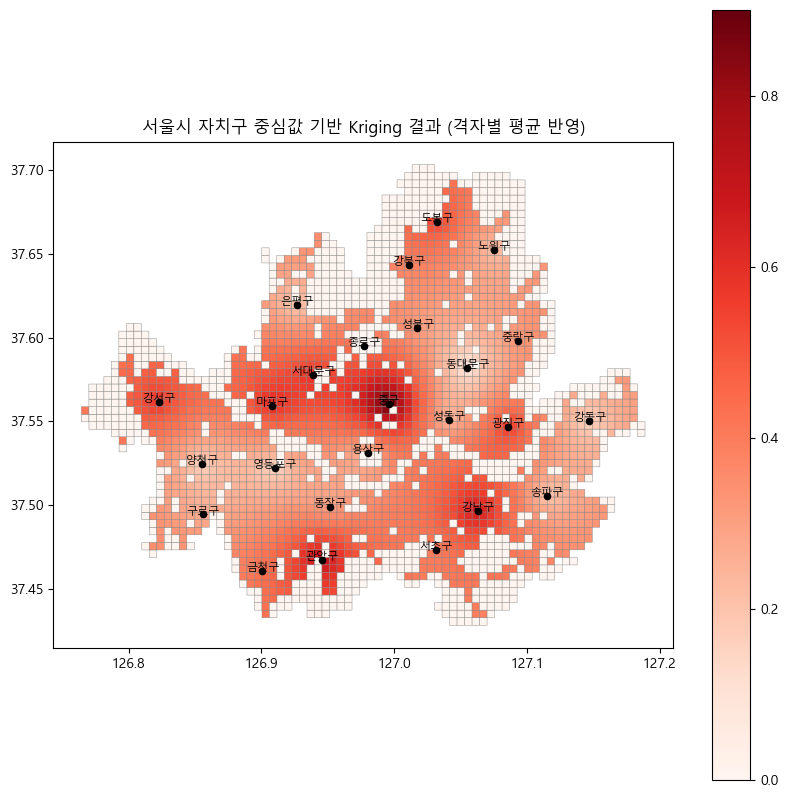

In [21]:
#%%
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy.interpolate import griddata

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
seoul = gpd.read_file("서울시 상권분석서비스(영역-행정동).shp")

minx, miny, maxx, maxy = seoul.total_bounds
res = 500  # 500m
x_coords = np.arange(minx, maxx, res)
y_coords = np.arange(miny, maxy, res)
grid_polys = []
grid_centers = []
for x in x_coords:
    for y in y_coords:
        poly = Polygon([(x,y),(x+res,y),(x+res,y+res),(x,y+res)])
        grid_polys.append(poly)
        grid_centers.append((x+res/2, y+res/2))

grid = gpd.GeoDataFrame(geometry=grid_polys, crs=seoul.crs)
grid["cx"] = [c[0] for c in grid_centers]
grid["cy"] = [c[1] for c in grid_centers]

grid_in_seoul = grid[grid.intersects(seoul.unary_union)]

seoul_wgs = seoul.to_crs(epsg=4326)
grid_wgs = grid_in_seoul.to_crs(epsg=4326)

#grid_wgs.to_file("C:/Users/jeongmin/Downloads/seoul_grid_500m.shp", encoding='utf-8')

seoul_wgs["GU_CODE"] = seoul_wgs["ADSTRD_CD"].astype(str).str[:5]
seoul_wgs = seoul_wgs.dissolve(by="GU_CODE")
seoul_wgs["centroid"] = seoul_wgs.geometry.centroid
seoul_wgs["cx"] = seoul_wgs.centroid.x
seoul_wgs["cy"] = seoul_wgs.centroid.y
print(seoul_wgs.head) # 구 없음 

#%%
################################
#
#
#
# seoul_wgs["value"]에 보간하고 싶은 값이 들어가도록!!!
#
#
#
################################


seoul_wgs["value"] = np.random.randint(0, 100, len(seoul_wgs)) # 이따 바꾸기 
df_gu = seoul_wgs[["cx", "cy", "value"]].reset_index()
gu_name_map = {
    "11110": "종로구",
    "11140": "중구",
    "11170": "용산구",
    "11200": "성동구",
    "11215": "광진구",
    "11230": "동대문구",
    "11260": "중랑구",
    "11290": "성북구",
    "11305": "강북구",
    "11320": "도봉구",
    "11350": "노원구",
    "11380": "은평구",
    "11410": "서대문구",
    "11440": "마포구",
    "11470": "양천구",
    "11500": "강서구",
    "11530": "구로구",
    "11545": "금천구",
    "11560": "영등포구",
    "11590": "동작구",
    "11620": "관악구",
    "11650": "서초구",
    "11680": "강남구",
    "11710": "송파구",
    "11740": "강동구"
}

df_gu["GU_NM"] = df_gu["GU_CODE"].map(gu_name_map)
df_gu = df_gu[["GU_CODE", "GU_NM", "cx", "cy", "value"]]


# 구별 임의값 (예: 0~100 사이)
df.rename(columns={'자치구': 'GU_NM'}, inplace=True)

df_gu_1 = pd.merge(df_gu, df, how = 'left', on = 'GU_NM') 
print(df_gu_1.head())


points_gdf = gpd.GeoDataFrame(
    df_gu_1,
    geometry=gpd.points_from_xy(df_gu.cx, df_gu.cy),
    crs=grid_wgs.crs  # grid_wgs 좌표계와 동일하게 맞춤
)

grid_with_value = gpd.sjoin(
    grid_wgs,          # 왼쪽: 격자
    points_gdf[["GU_NM", "최종변수", "geometry"]],  # 오른쪽: 구 중심점
    how="left",
    predicate="contains"   # 중심점이 폴리곤 안에 있을 때만 매칭
)



# %%
from shapely.geometry import Point
from pykrige.ok import OrdinaryKriging

seoul_m = seoul.to_crs(epsg=5186)
points_m = points_gdf.to_crs(epsg=5186)
grid_m = grid_wgs.to_crs(epsg=5186)

x = points_m.geometry.x.values
y = points_m.geometry.y.values
v = points_m['최종변수'].values

OK = OrdinaryKriging(
    x, y, v,
    variogram_model="exponential",
    variogram_parameters={"sill": 1.0, "range": 8000, "nugget": 0.1},
    verbose=False, enable_plotting=False
)

minx, miny, maxx, maxy = seoul_m.total_bounds
res = 300  # 300m 해상도 보간 (격자보다 조금 더 촘촘하게)
gridx = np.arange(minx, maxx, res)
gridy = np.arange(miny, maxy, res)
z, ss = OK.execute("grid", gridx, gridy)
xx, yy = np.meshgrid(gridx, gridy)
zz = np.array(z)

# ───────────────────────────────
#  Kriging 결과를 포인트 GeoDataFrame으로 변환
# ───────────────────────────────
krig_points = gpd.GeoDataFrame(
    {"최종변수": zz.ravel()},
    geometry=[Point(xy) for xy in zip(xx.ravel(), yy.ravel())],
    crs=seoul_m.crs
)

# ───────────────────────────────
# 격자(grid_wgs)별 평균값 계산
# ───────────────────────────────
krig_points = krig_points[krig_points.within(seoul_m.unary_union)]
joined = gpd.sjoin(krig_points, grid_m, predicate="within")
grid_values = joined.groupby(joined.index_right)["최종변수"].mean()
grid_m["kriging_value"] = grid_values

# --- 버스 정류장이 없는 격자를 0으로 마스킹하는 코드 ---

# 1. 버스 정류장 데이터 로드 및 좌표계 통일
print("버스 정류장 데이터를 로드하고 좌표계를 통일합니다...")
df_bus = pd.read_csv("서울시 버스정류소 위치정보.csv", encoding="cp949")
df_bus = df_bus.rename(columns={"X좌표": "경도", "Y좌표": "위도"})
df_bus["geometry"] = [Point(x, y) for x, y in zip(df_bus["경도"], df_bus["위도"])]
geo_bus = gpd.GeoDataFrame(df_bus, crs="EPSG:4326", geometry="geometry")

# Kriging 격자인 grid_m과 동일한 좌표계로 변환해야 정확한 위치 비교가 가능합니다.
geo_bus_m = geo_bus.to_crs(grid_m.crs)

# 2. 격자(grid_m)와 버스 정류장(geo_bus_m)을 공간 조인(sjoin)
# how='left': 버스정류장이 없는 격자도 결과에 남기기 위함
# predicate='contains': 격자(Polygon)가 버스정류장(Point)을 포함하는지 확인
print("격자 내 버스 정류장 존재 여부를 확인합니다...")
joined_grid_bus = gpd.sjoin(grid_m, geo_bus_m, how="left", predicate="contains")

# 3. 각 격자별로 포함된 버스 정류장 수 계산
# sjoin 결과에서 원본 격자(grid_m)의 인덱스로 그룹화하고,
# 매칭된 버스 정류장의 수('index_right')를 셉니다.
bus_counts_per_grid = joined_grid_bus.groupby(joined_grid_bus.index)['index_right'].count()

# 4. 버스 정류장 수가 0인 격자의 인덱스 찾기
no_bus_indices = bus_counts_per_grid[bus_counts_per_grid == 0].index

# 5. 해당 격자의 'kriging_value'를 0으로 설정
print(f"총 {len(no_bus_indices)}개의 격자에 버스 정류장이 없어 값을 0으로 변경합니다.")
grid_m.loc[no_bus_indices, 'kriging_value'] = 0

# --- 마스킹 코드 종료 ---

grid_plot = grid_m.to_crs(epsg=4326)
points_plot = points_m.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))
grid_plot.plot(ax=ax, column="kriging_value", cmap="Reds", legend=True,
               edgecolor="gray", linewidth=0.3)
points_plot.plot(ax=ax, color="black", markersize=20)
for i, row in points_plot.iterrows():
    plt.text(row.cx, row.cy, row.GU_NM, fontsize=8, ha="center")
plt.title("서울시 자치구 중심값 기반 Kriging 결과 (격자별 평균 반영)")
plt.show()


In [22]:
grid_m_demand = grid_m
grid_m_demand.columns = ['geometry', 'cx', 'cy', 'demand_value']
grid_m_demand

,geometry,cx,cy,demand_value
27,"POLYGON ((179189.762 550047.407, 179689.762 55...",179439.7616,450297.4067,0.000000
28,"POLYGON ((179189.762 550547.407, 179689.762 55...",179439.7616,450797.4067,0.407868
87,"POLYGON ((179689.762 549547.407, 180189.762 54...",179939.7616,449797.4067,0.000000
88,"POLYGON ((179689.762 550047.407, 180189.762 55...",179939.7616,450297.4067,0.000000
89,"POLYGON ((179689.762 550547.407, 180189.762 55...",179939.7616,450797.4067,0.000000
...,...,...,...,...
4482,"POLYGON ((215689.762 551047.407, 216189.762 55...",215939.7616,451297.4067,0.299616
4483,"POLYGON ((215689.762 551547.407, 216189.762 55...",215939.7616,451797.4067,0.305717
4484,"POLYGON ((215689.762 552047.407, 216189.762 55...",215939.7616,452297.4067,0.000000
4539,"POLYGON ((216189.762 549047.407, 216689.762 54...",216439.7616,449297.4067,0.000000


In [23]:
# --- 병합 전 CRS(좌표계) 통일 확인 ---
# 세 GeoDataFrame의 좌표계가 동일한지 확인합니다. 다르다면 통일해야 합니다.
# 예: 

grid_m_demand = grid_m_demand.to_crs(geo_shp.crs)
grid_m_comm = grid_m_comm.to_crs(geo_shp.crs)

# 1. geo_shp와 grid_m_demand를 공간 조인
joined_demand = gpd.sjoin(geo_shp, grid_m_demand[['demand_value', 'geometry']], 
                          how='left', predicate='intersects')

# 2. 중복을 방지하기 위해 원본 geo_shp 인덱스로 그룹화 후 평균값 계산
# (겹치는 폴리곤이 여러 개일 경우를 대비. mean(), max(), min() 등 사용 가능)
demand_values = joined_demand.groupby(joined_demand.index)['demand_value'].mean()

# 3. 계산된 값을 geo_shp의 새 열로 추가
geo_shp['demand_value'] = demand_values

# 4. grid_m_comm에 대해서도 동일한 과정 반복
joined_comm = gpd.sjoin(geo_shp, grid_m_comm[['commercial_value', 'geometry']], 
                        how='left', predicate='intersects')
comm_values = joined_comm.groupby(joined_comm.index)['commercial_value'].mean()
geo_shp['comm_value'] = comm_values

# 결과 확인
print(geo_shp[['demand_value', 'comm_value', 'geometry']].head())

   demand_value  comm_value                                           geometry
0      0.081574    0.388986  POLYGON ((126.7645 37.54971, 126.76449 37.5542...
1      0.081574    0.259324  POLYGON ((126.76449 37.55422, 126.76447 37.558...
2      0.000000    0.000000  POLYGON ((126.77017 37.54522, 126.77016 37.549...
3      0.058267    0.194493  POLYGON ((126.77016 37.54972, 126.77015 37.554...
4      0.058267    0.155594  POLYGON ((126.77015 37.55423, 126.77013 37.558...


In [24]:
geo_shp_final = geo_shp[['geometry', 'total_access','demand_value', 'comm_value']]
geo_shp_final.columns = ['geometry', 'transport','demmand', 'commerce']
geo_shp_final

,geometry,transport,demmand,commerce
0,"POLYGON ((126.7645 37.54971, 126.76449 37.5542...",0.000000,0.081574,0.388986
1,"POLYGON ((126.76449 37.55422, 126.76447 37.558...",1.110443,0.081574,0.259324
2,"POLYGON ((126.77017 37.54522, 126.77016 37.549...",0.000000,0.000000,0.000000
3,"POLYGON ((126.77016 37.54972, 126.77015 37.554...",0.000000,0.058267,0.194493
4,"POLYGON ((126.77015 37.55423, 126.77013 37.558...",0.000000,0.058267,0.155594
...,...,...,...,...
2634,"POLYGON ((127.17757 37.55882, 127.17758 37.563...",1.306588,0.297073,0.728956
2635,"POLYGON ((127.17758 37.56333, 127.1776 37.5678...",1.977703,0.225957,0.728496
2636,"POLYGON ((127.1776 37.56783, 127.17761 37.5723...",0.000000,0.152859,0.546532
2637,"POLYGON ((127.18319 37.54079, 127.1832 37.5453...",0.000000,0.000000,0.000000


In [25]:
from sklearn.preprocessing import MinMaxScaler

# --- 방법 1: scikit-learn 라이브러리 사용 (추천) ---
# 정규화할 열들을 리스트로 지정합니다.
columns_to_normalize = ['transport', 'demmand', 'commerce']

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# 지정된 열들에 대해 정규화를 수행하고, 새로운 열 이름으로 저장합니다.
# 예: 'transport' -> 'transport_norm'
for col in columns_to_normalize:
    # reshape(-1, 1)은 1차원 데이터를 2차원으로 변환해 scaler에 맞게 조정합니다.
    geo_shp_final[f'{col}_norm'] = scaler.fit_transform(geo_shp_final[[col]])


C:\Users\Mycom\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Mycom\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Mycom\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is tryin

   transport   demmand  commerce  total_trans
0   0.000000  0.081574  0.388986     0.060734
1   1.110443  0.081574  0.259324     0.269489
2   0.000000  0.000000  0.000000     0.000000
3   0.000000  0.058267  0.194493     0.034817
4   0.000000  0.058267  0.155594     0.030821


C:\Users\Mycom\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


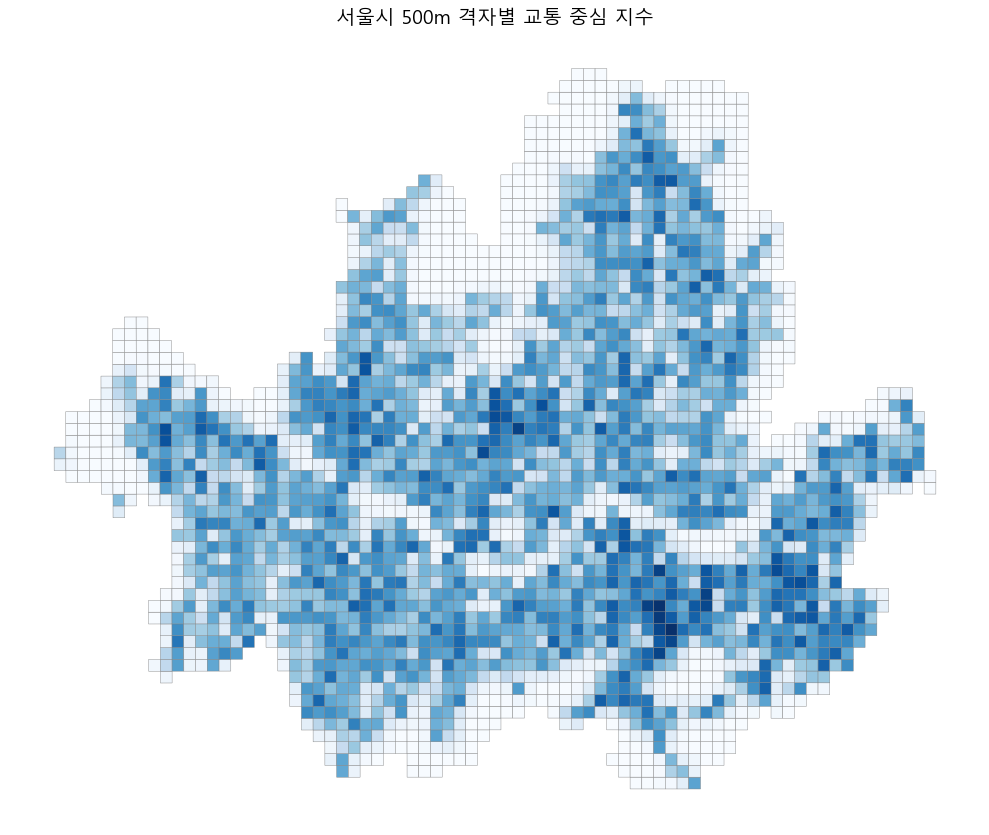

In [26]:
# 교통 중심 
trans_weight = 0.6
demm_weight = 0.2
comm_weight = 0.2

# 정규화된 값들을 더하여 최종 지수 'total'을 계산합니다.
geo_shp_final["total_trans"] = (
    geo_shp_final["transport_norm"] * trans_weight+
    geo_shp_final["demmand_norm"] * demm_weight+
    geo_shp_final["commerce_norm"] * comm_weight
)

# 결과 확인
print(geo_shp_final[['transport', 'demmand', 'commerce', 'total_trans']].head())

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
geo_shp_final.plot(
    ax=ax,
    column="total_trans",
    cmap="Blues",
    legend=False,
    edgecolor="gray",
    linewidth=0.3
)

ax.set_title("서울시 500m 격자별 교통 중심 지수", fontsize=14)
ax.set_axis_off()

plt.tight_layout()
plt.savefig('서울시 교통 중심 지수.png')
plt.show()

공간 가중치 행렬을 생성합니다...
LISA 분석을 수행하여 공간 클러스터를 찾습니다...


C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\663692770.py:9: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = libpysal.weights.Queen.from_dataframe(geo_shp_final)


총 2639개 격자 중, 통계적으로 유의미한 핫스팟(High-High)은 197개 입니다.


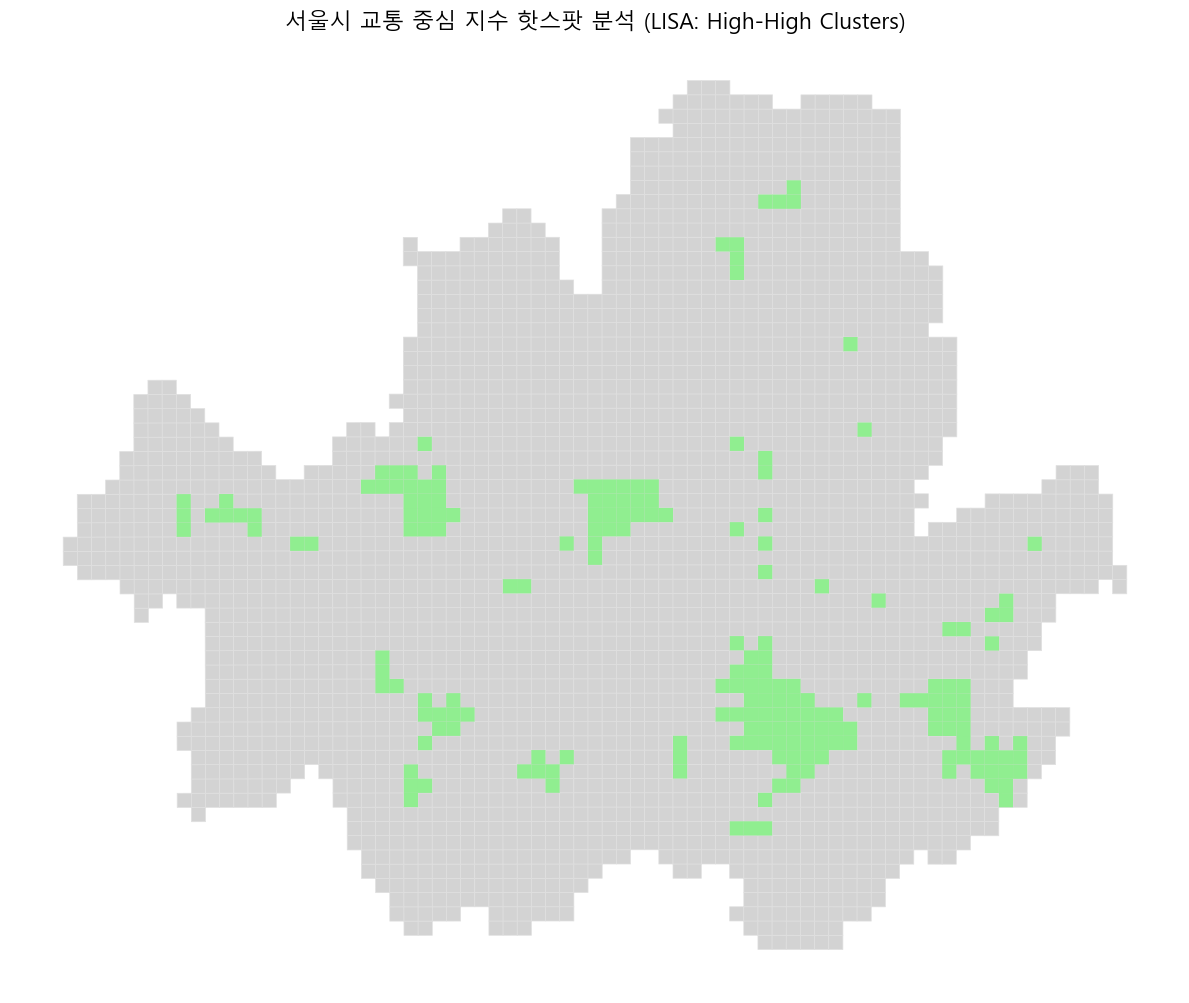

In [27]:
import matplotlib.pyplot as plt
import libpysal.weights
from esda.moran import Moran_Local

# --- 1. 공간 가중치 행렬(Spatial Weights Matrix) 생성 ---
# 각 격자가 어떤 다른 격자와 이웃인지를 정의하는 단계입니다.
# 'Queen' 방식은 모서리나 변을 공유하는 모든 이웃을 포함합니다.
print("공간 가중치 행렬을 생성합니다...")
wq = libpysal.weights.Queen.from_dataframe(geo_shp_final)
wq.transform = 'r' # 가중치를 행 표준화합니다.


# --- 2. LISA 분석 수행 ---
# 'total_trans' 열에 대해 Local Moran's I 통계량을 계산합니다.
print("LISA 분석을 수행하여 공간 클러스터를 찾습니다...")
lisa = Moran_Local(geo_shp_final['total_trans'], wq)


# --- 3. 유의미한 High-High 클러스터(핫스팟) 필터링 ---
# lisa.q는 클러스터의 종류를 나타냅니다: 1(HH), 2(LH), 3(LL), 4(HL)
# lisa.p_sim은 각 클러스터의 p-value(통계적 유의성)를 나타냅니다.

# 조건 1: High-High 클러스터일 것 (lisa.q == 1)
# 조건 2: 통계적으로 유의미할 것 (p-value < 0.05)
is_significant_hotspot = (lisa.q == 1) & (lisa.p_sim < 0.005)
hotspots = geo_shp_final[is_significant_hotspot]

print(f"총 {len(geo_shp_final)}개 격자 중, 통계적으로 유의미한 핫스팟(High-High)은 {len(hotspots)}개 입니다.")


# --- 4. 시각화 ---
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# 4-1. [1단계] 배경 지도 그리기: 전체 격자를 연한 회색으로 표시합니다.
geo_shp_final.plot(
    ax=ax,
    color="lightgray",
    edgecolor="#e0e0e0",
    linewidth=0.5
)

# 4-2. [2단계] 핫스팟(High-High) 지역 덧그리기: 필터링된 핫스팟만 빨간색으로 강조합니다.
hotspots.plot(
    ax=ax,
    color='lightgreen',          # 내부 색상을 빨간색으로 지정
#    edgecolor='black',    # 테두리 색상을 검은색으로
    linewidth=0.5
)

ax.set_title("서울시 교통 중심 지수 핫스팟 분석 (LISA: High-High Clusters)", fontsize=16)
ax.set_axis_off()

plt.tight_layout()
plt.savefig('서울시 교통 중심 지수 (LISA).png')

plt.show()

C:\Users\Mycom\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


   transport_norm  demmand_norm  commerce_norm
0        0.000000      0.103846       0.199823
1        0.370128      0.103846       0.133215
2        0.000000      0.000000       0.000000
3        0.000000      0.074176       0.099911
4        0.000000      0.074176       0.079929


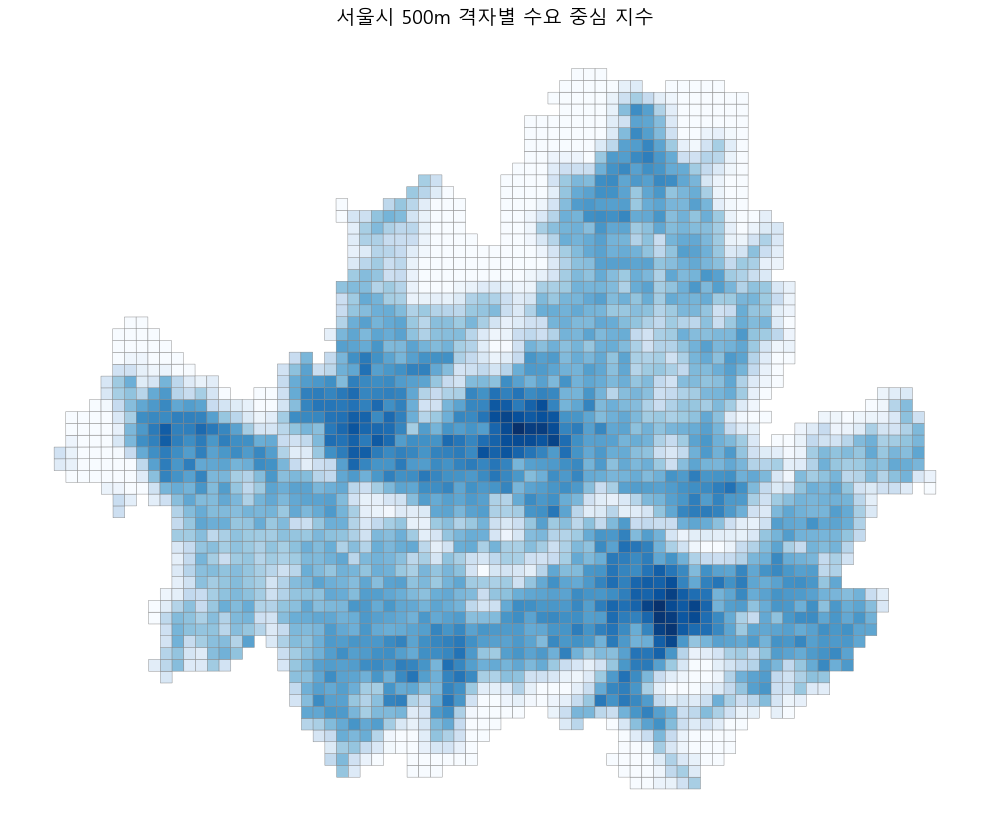

In [28]:
# 수요 중심 
trans_weight = 0.2
demm_weight = 0.6
comm_weight = 0.2

# 정규화된 값들을 더하여 최종 지수 'total'을 계산합니다.
geo_shp_final["total_demm"] = (
    geo_shp_final["transport_norm"] * trans_weight+
    geo_shp_final["demmand_norm"] * demm_weight+
    geo_shp_final["commerce_norm"] * comm_weight
)

# 결과 확인
print(geo_shp_final[['transport_norm', 'demmand_norm', 'commerce_norm']].head())

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
geo_shp_final.plot(
    ax=ax,
    column="total_demm",
    cmap="Blues",
    legend=False,
    edgecolor="gray",
    linewidth=0.3
)

ax.set_title("서울시 500m 격자별 수요 중심 지수", fontsize=14)
ax.set_axis_off()

plt.tight_layout()
plt.savefig('서울시 수요 중심 지수.png')

plt.show()

공간 가중치 행렬을 생성합니다...
LISA 분석을 수행하여 공간 클러스터를 찾습니다...


C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\15871766.py:9: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = libpysal.weights.Queen.from_dataframe(geo_shp_final)


총 2639개 격자 중, 통계적으로 유의미한 핫스팟(High-High)은 360개 입니다.


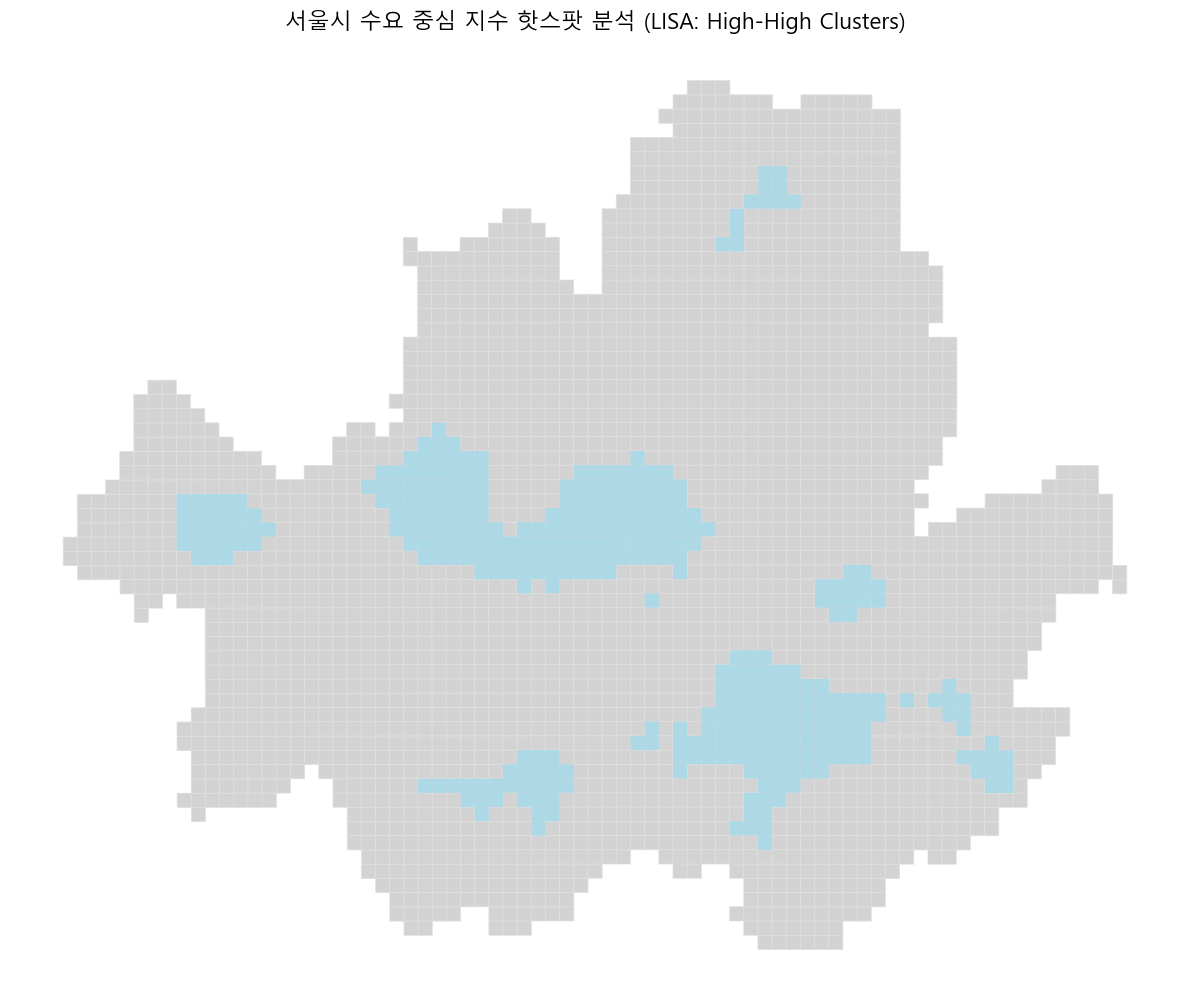

In [29]:
import matplotlib.pyplot as plt
import libpysal.weights
from esda.moran import Moran_Local

# --- 1. 공간 가중치 행렬(Spatial Weights Matrix) 생성 ---
# 각 격자가 어떤 다른 격자와 이웃인지를 정의하는 단계입니다.
# 'Queen' 방식은 모서리나 변을 공유하는 모든 이웃을 포함합니다.
print("공간 가중치 행렬을 생성합니다...")
wq = libpysal.weights.Queen.from_dataframe(geo_shp_final)
wq.transform = 'r' # 가중치를 행 표준화합니다.


# --- 2. LISA 분석 수행 ---
# 'total_trans' 열에 대해 Local Moran's I 통계량을 계산합니다.
print("LISA 분석을 수행하여 공간 클러스터를 찾습니다...")
lisa = Moran_Local(geo_shp_final['total_demm'], wq)


# --- 3. 유의미한 High-High 클러스터(핫스팟) 필터링 ---
# lisa.q는 클러스터의 종류를 나타냅니다: 1(HH), 2(LH), 3(LL), 4(HL)
# lisa.p_sim은 각 클러스터의 p-value(통계적 유의성)를 나타냅니다.

# 조건 1: High-High 클러스터일 것 (lisa.q == 1)
# 조건 2: 통계적으로 유의미할 것 (p-value < 0.05)
is_significant_hotspot = (lisa.q == 1) & (lisa.p_sim < 0.005)
hotspots = geo_shp_final[is_significant_hotspot]

print(f"총 {len(geo_shp_final)}개 격자 중, 통계적으로 유의미한 핫스팟(High-High)은 {len(hotspots)}개 입니다.")


# --- 4. 시각화 ---
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# 4-1. [1단계] 배경 지도 그리기: 전체 격자를 연한 회색으로 표시합니다.
geo_shp_final.plot(
    ax=ax,
    color="lightgray",
    edgecolor="#e0e0e0",
    linewidth=0.5
)

# 4-2. [2단계] 핫스팟(High-High) 지역 덧그리기: 필터링된 핫스팟만 빨간색으로 강조합니다.
hotspots.plot(
    ax=ax,
    color='lightblue',          # 내부 색상을 빨간색으로 지정
#    edgecolor='black',    # 테두리 색상을 검은색으로
    linewidth=0.5
)

ax.set_title("서울시 수요 중심 지수 핫스팟 분석 (LISA: High-High Clusters)", fontsize=16)
ax.set_axis_off()

plt.tight_layout()
plt.savefig('서울시 수요 중심 지수(LISA).png')

plt.show()

C:\Users\Mycom\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


   transport_norm  demmand_norm  commerce_norm
0        0.000000      0.103846       0.199823
1        0.370128      0.103846       0.133215
2        0.000000      0.000000       0.000000
3        0.000000      0.074176       0.099911
4        0.000000      0.074176       0.079929


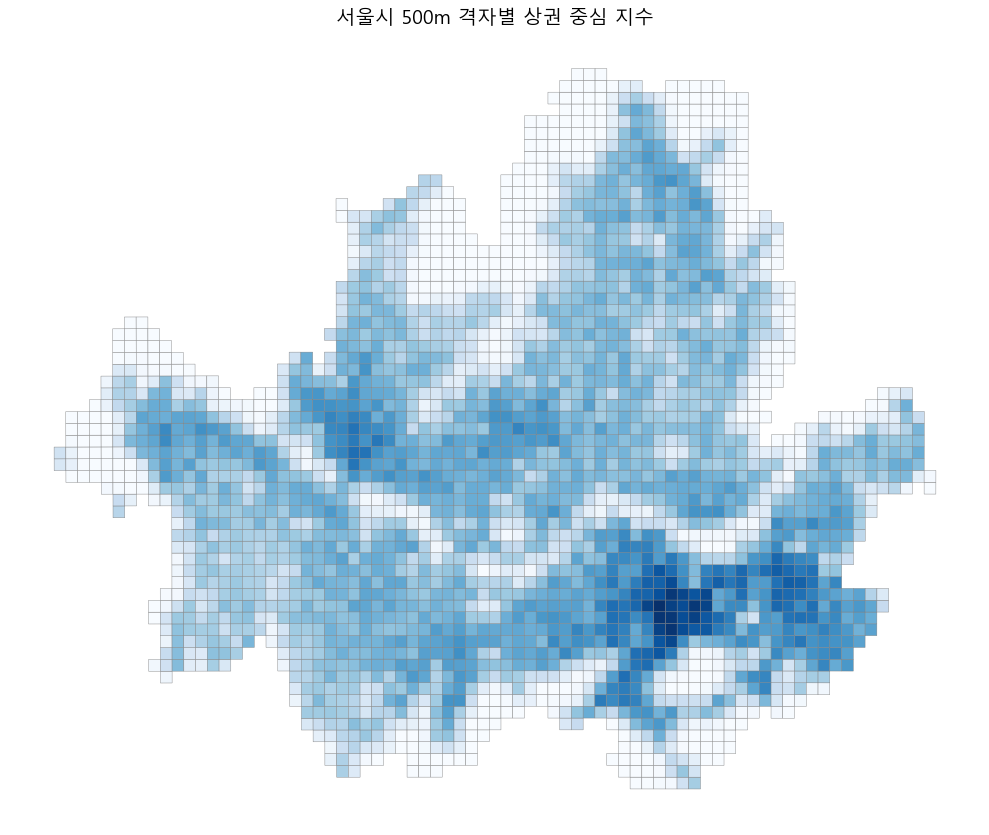

In [30]:
# 상권 중심 
trans_weight = 0.2
demm_weight = 0.2
comm_weight = 0.6

# 정규화된 값들을 더하여 최종 지수 'total'을 계산합니다.
geo_shp_final["total_comm"] = (
    geo_shp_final["transport_norm"] * trans_weight+
    geo_shp_final["demmand_norm"] * demm_weight+
    geo_shp_final["commerce_norm"] * comm_weight
)

# 결과 확인
print(geo_shp_final[['transport_norm', 'demmand_norm', 'commerce_norm']].head())

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
geo_shp_final.plot(
    ax=ax,
    column="total_comm",
    cmap="Blues",
    legend=False,
    edgecolor="gray",
    linewidth=0.3
)

ax.set_title("서울시 500m 격자별 상권 중심 지수", fontsize=14)
ax.set_axis_off()

plt.tight_layout()
plt.savefig('서울시 상권 중심 지수.png')

plt.show()

공간 가중치 행렬을 생성합니다...
LISA 분석을 수행하여 공간 클러스터를 찾습니다...


C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\50255122.py:9: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = libpysal.weights.Queen.from_dataframe(geo_shp_final)


총 2639개 격자 중, 통계적으로 유의미한 핫스팟(High-High)은 325개 입니다.


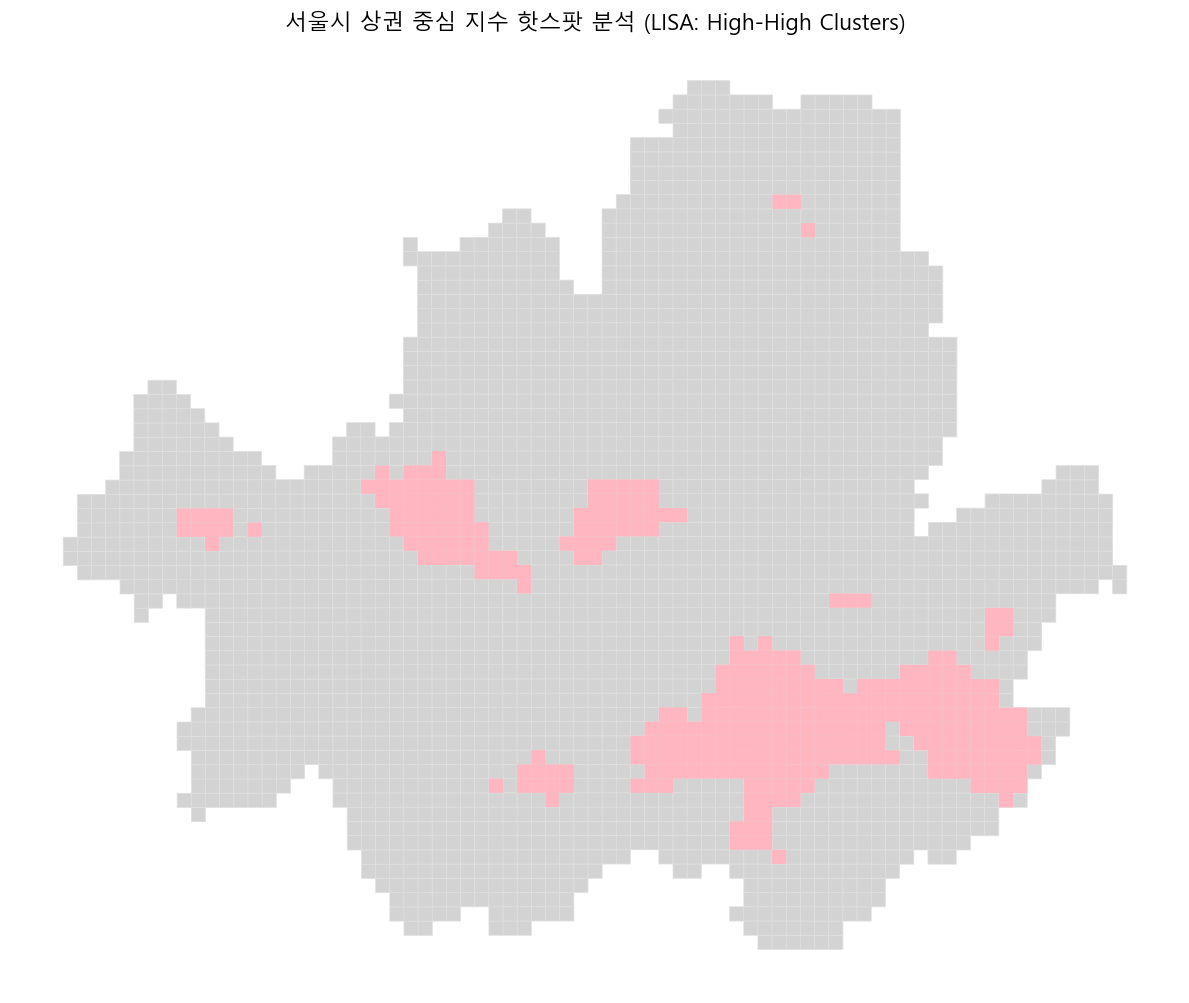

In [31]:
import matplotlib.pyplot as plt
import libpysal.weights
from esda.moran import Moran_Local

# --- 1. 공간 가중치 행렬(Spatial Weights Matrix) 생성 ---
# 각 격자가 어떤 다른 격자와 이웃인지를 정의하는 단계입니다.
# 'Queen' 방식은 모서리나 변을 공유하는 모든 이웃을 포함합니다.
print("공간 가중치 행렬을 생성합니다...")
wq = libpysal.weights.Queen.from_dataframe(geo_shp_final)
wq.transform = 'r' # 가중치를 행 표준화합니다.


# --- 2. LISA 분석 수행 ---
# 'total_trans' 열에 대해 Local Moran's I 통계량을 계산합니다.
print("LISA 분석을 수행하여 공간 클러스터를 찾습니다...")
lisa = Moran_Local(geo_shp_final['total_comm'], wq)


# --- 3. 유의미한 High-High 클러스터(핫스팟) 필터링 ---
# lisa.q는 클러스터의 종류를 나타냅니다: 1(HH), 2(LH), 3(LL), 4(HL)
# lisa.p_sim은 각 클러스터의 p-value(통계적 유의성)를 나타냅니다.

# 조건 1: High-High 클러스터일 것 (lisa.q == 1)
# 조건 2: 통계적으로 유의미할 것 (p-value < 0.05)
is_significant_hotspot = (lisa.q == 1) & (lisa.p_sim < 0.005)
hotspots = geo_shp_final[is_significant_hotspot]

print(f"총 {len(geo_shp_final)}개 격자 중, 통계적으로 유의미한 핫스팟(High-High)은 {len(hotspots)}개 입니다.")


# --- 4. 시각화 ---
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# 4-1. [1단계] 배경 지도 그리기: 전체 격자를 연한 회색으로 표시합니다.
geo_shp_final.plot(
    ax=ax,
    color="lightgray",
    edgecolor="#e0e0e0",
    linewidth=0.5
)

# 4-2. [2단계] 핫스팟(High-High) 지역 덧그리기: 필터링된 핫스팟만 빨간색으로 강조합니다.
hotspots.plot(
    ax=ax,
    color='lightpink',          # 내부 색상을 빨간색으로 지정
#    edgecolor='black',    # 테두리 색상을 검은색으로
    linewidth=0.5
)

ax.set_title("서울시 상권 중심 지수 핫스팟 분석 (LISA: High-High Clusters)", fontsize=16)
ax.set_axis_off()

plt.tight_layout()
plt.savefig('서울시 상권 중심 지수(LISA).png')

plt.show()

In [32]:
columns_for_corr = ['transport_norm', 'demmand_norm', 'commerce_norm']
corr_matrix = geo_shp_final[columns_for_corr].corr()

print("--- 상관관계 행렬 ---")
print(corr_matrix)

--- 상관관계 행렬 ---
                transport_norm  demmand_norm  commerce_norm
transport_norm        1.000000      0.543083       0.584813
demmand_norm          0.543083      1.000000       0.695824
commerce_norm         0.584813      0.695824       1.000000


In [33]:
from sklearn.decomposition import PCA
import numpy as np

# 1. 정규화된 데이터 준비
features = geo_shp_final[['transport_norm', 'demmand_norm', 'commerce_norm']]

# 2. PCA 모델 생성 및 학습
# n_components=1: 가장 중요한 첫 번째 주성분만 추출
pca = PCA(n_components=1)
pca.fit(features)

# 3. 각 변수가 제1주성분에 기여하는 정도(고유벡터)를 추출
# pca.components_는 각 변수의 기여도를 나타냅니다.
# [0]은 첫 번째 주성분을 의미합니다.
loadings = pca.components_[0]

# 4. 기여도를 가중치로 변환 (절대값 -> 합이 1이 되도록 정규화)
abs_loadings = np.abs(loadings)
weights_pca = abs_loadings / np.sum(abs_loadings)

print("--- PCA 기반 가중치 ---")
print(f"Transport 가중치: {weights_pca[0]:.3f}")
print(f"Demmand 가중치: {weights_pca[1]:.3f}")
print(f"Commerce 가중치: {weights_pca[2]:.3f}")

# 5. 계산된 가중치로 최종 지수 계산
geo_shp_final['total_pca_weighted'] = (
    geo_shp_final['transport_norm'] * weights_pca[0] +
    geo_shp_final['demmand_norm'] * weights_pca[1] +
    geo_shp_final['commerce_norm'] * weights_pca[2]
)

--- PCA 기반 가중치 ---
Transport 가중치: 0.504
Demmand 가중치: 0.248
Commerce 가중치: 0.248


C:\Users\Mycom\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


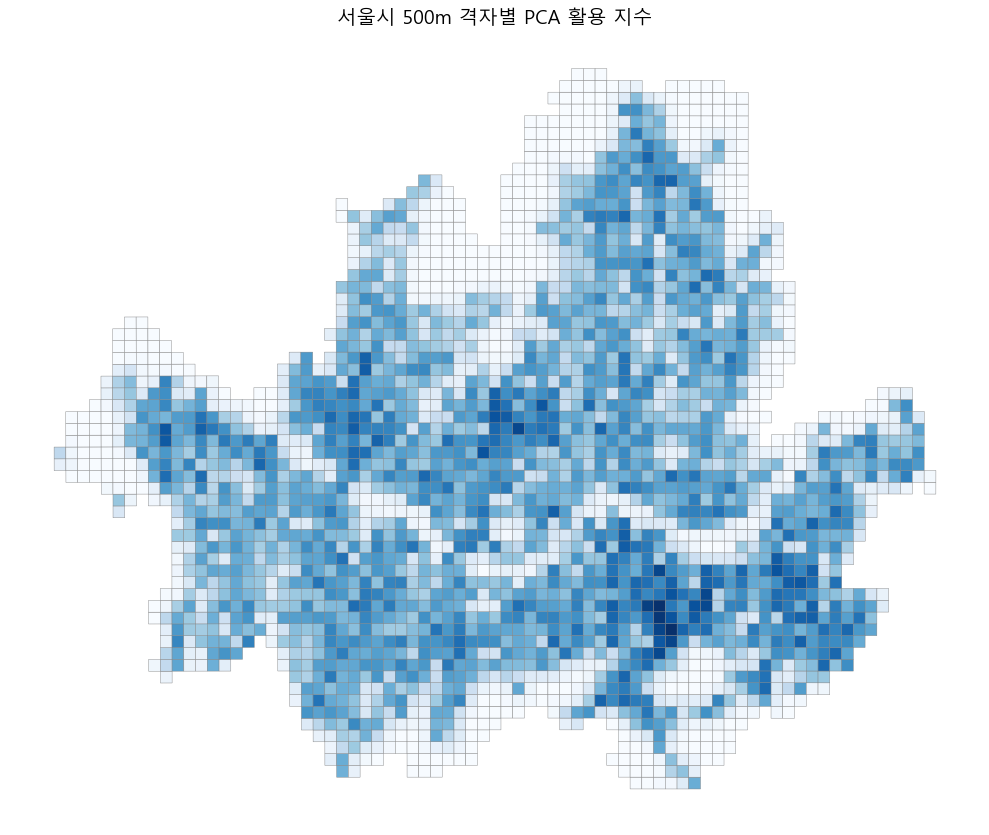

In [34]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
geo_shp_final.plot(
    ax=ax,
    column="total_pca_weighted",
    cmap="Blues",
    legend=False,
    edgecolor="gray",
    linewidth=0.3
)

ax.set_title("서울시 500m 격자별 PCA 활용 지수", fontsize=14)
ax.set_axis_off()

plt.tight_layout()
plt.savefig('서울시 PCA 활용 지수.png')

plt.show()

# 네이버 부동산 크롤링 => 실패 ㅠㅠ 손크롤링한 청년센터들로 대체

['서울특별시 양천구 오목로 359',
 '서울특별시 도봉구 마들로11길 75',
 '서울특별시 강동구 올림픽로 610',
 '서울특별시 성동구 왕십리도선동 왕십리로 350',
 '서울특별시 광진구 능동로 245',
 '서울\xa0관악구 신림로 99',
 '서울특별시 은평구 통일로67길 9',
 '서울특별시 성북구 종암로5길 7',
 '서울특별시 노원구 상계동 731-5',
 '서울특별시 금천구 독산동 시흥대로138길 10-11',
 '서울특별시 동대문구 전농동 591-53',
 '서울특별시 용산구 원효로97길 15',
 '서울특별시 서초구 남부순환로 2567',
 '서울특별시 용산구 원효로97길 15',
 '서울특별시 중랑구 중랑역로 159',
 '서울특별시 중구 다산로38길 85',
 '서초구 청두곶2길 22',
 '서초구 남부순환로339길 47-1',
 '서초구 반포대로1길 53-3',
 '서초구 방배천로 34길 31',
 '서초구 전원말안길 2',
 '서울특별시 중랑구 망우동 454-7',
 '서울특별시 중랑구 망우동 454-7',
 '서울특별시 중랑구 망우동 454-7',
 '서울특별시 구로구 중앙로3길 18-8',
 '서울특별시 강북구 오현로 145',
 '중랑구 면목로 45길 3-2',
 '서울특별시 서대문구 연희로 189',
 '구로구\xa0디지털로19길 22',
 '구로구\xa0오리로 1130',
 '서울특별시 양천구 목동중앙본로 120',
 '서울특별시 구로구 구로동 디지털로31길 109',
 '서초구 강남대로 12길 44',
 '서초구 방배로23길 31-6']

서울특별시 양천구 오목로 359 → (126.877307343, 37.524590611)
서울특별시 도봉구 마들로11길 75 → (127.048745514, 37.653159531)
서울특별시 강동구 올림픽로 610 → (127.122972441, 37.535793135)
서울특별시 성동구 왕십리도선동 왕십리로 350 → (127.031416839, 37.563783427)
서울특별시 광진구 능동로 245 → (127.076537085, 37.552233453)
서울 관악구 신림로 99 → (126.938429791, 37.470228091)
서울특별시 은평구 통일로67길 9 → (126.928467247, 37.610712084)
서울특별시 성북구 종암로5길 7 → (127.035444123, 37.594392705)
서울특별시 노원구 상계동 731-5 → (127.06025843821644, 37.65380534062311)
서울특별시 금천구 독산동 시흥대로138길 10-11 → (126.899284173, 37.47216693)
서울특별시 동대문구 전농동 591-53 → (127.04694970561155, 37.58093956307145)
서울특별시 용산구 원효로97길 15 → (126.969372512, 37.541417879)
서울특별시 서초구 남부순환로 2567 → (127.031299696, 37.484618806)
서울특별시 용산구 원효로97길 15 → (126.969372512, 37.541417879)
서울특별시 중랑구 중랑역로 159 → (127.076419469, 37.607574805)
서울특별시 중구 다산로38길 85 → (127.019665013, 37.561425481)
서초구 청두곶2길 22 → (126.986445657, 37.478441263)
서초구 남부순환로339길 47-1 → (127.021722344, 37.48490742)
서초구 반포대로1길 53-3 → (127.010878538, 37.48281143)
서초구 방

,주소,경도,위도
0,서울특별시 양천구 오목로 359,126.877307,37.524591
1,서울특별시 도봉구 마들로11길 75,127.048746,37.653160
2,서울특별시 강동구 올림픽로 610,127.122972,37.535793
3,서울특별시 성동구 왕십리도선동 왕십리로 350,127.031417,37.563783
4,서울특별시 광진구 능동로 245,127.076537,37.552233


격자 좌표계: EPSG:4326


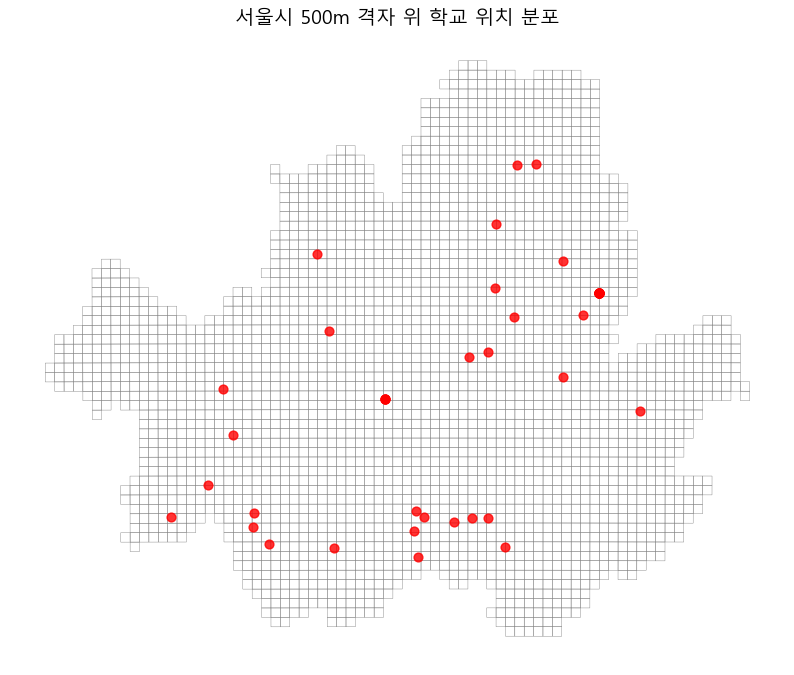

In [66]:
import requests
import pandas as pd
import time
school = pd.read_csv("청년센터 (1).csv", encoding='UTF-8') # 영끌 유휴공간 주소 

# VWorld API 설정
API_URL = "https://api.vworld.kr/req/address?"
VWORLD_KEY = "AA250E1D-0DDE-3751-8922-70BD2EAC0C37"  # 대괄호 없이

def get_coords(address):
    if not address.startswith("서울"):
        address = "서울특별시 " + address

    # 1차 시도 (자동 판별)
    addr_type = "road" if any(k in address for k in ["로", "길"]) else "parcel"
    params = {
        "service": "address",
        "request": "getcoord",
        "crs": "epsg:4326",
        "address": address,
        "format": "json",
        "type": addr_type,
        "key": VWORLD_KEY
    }

    res = requests.get(API_URL, params=params)
    if res.status_code == 200:
        data = res.json()
        try:
            x = float(data['response']['result']['point']['x'])
            y = float(data['response']['result']['point']['y'])
            return x, y
        except:
            # 2차 시도 — 다른 타입으로 재검색
            backup_type = "parcel" if addr_type == "road" else "road"
            params["type"] = backup_type
            res2 = requests.get(API_URL, params=params)
            if res2.status_code == 200:
                try:
                    x = float(res2.json()['response']['result']['point']['x'])
                    y = float(res2.json()['response']['result']['point']['y'])
                    return x, y
                except:
                    return None, None
    return None, None


# 🔹 주소 리스트로 변환
addresses = school["주소"].dropna().tolist()  # NaN 제거 후 리스트 변환
display(addresses)

# 🔹 반복 호출
coords = []
for addr in addresses:
    x, y = get_coords(addr)
    coords.append({"주소": addr, "경도": x, "위도": y})
    print(f"{addr} → ({x}, {y})")
    time.sleep(0.2)  # API 호출 제한 방지

# 🔹 결과 DataFrame
df = pd.DataFrame(coords)
display(df.head())

# 🔹 기존 데이터와 병합
school_geo = pd.merge(school, df, on="주소", how="left")

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
geo_shp = gpd.read_file("seoul_grid_500m.shp")
print("격자 좌표계:", geo_shp.crs)

# None 값이 있는 행 제거
school_clean = school_geo[(school_geo["경도"].notnull()) & (school_geo["위도"].notnull())]

points = gpd.GeoDataFrame(
    school_clean,
    geometry=[Point(xy) for xy in zip(school_clean["경도"], school_clean["위도"])],
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(10, 10))
geo_shp.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.3)
points.plot(ax=ax, color="red", markersize=40, alpha=0.8)
plt.title("서울시 500m 격자 위 학교 위치 분포", fontsize=14)
plt.axis("off")
plt.show()

공간 가중치 행렬을 생성합니다...
LISA 분석을 수행하여 공간 클러스터를 찾습니다...


C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\2977675267.py:12: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = libpysal.weights.Queen.from_dataframe(geo_shp_final)


총 2639개 격자 중, 통계적으로 유의미한 핫스팟(High-High)은 213개 입니다.


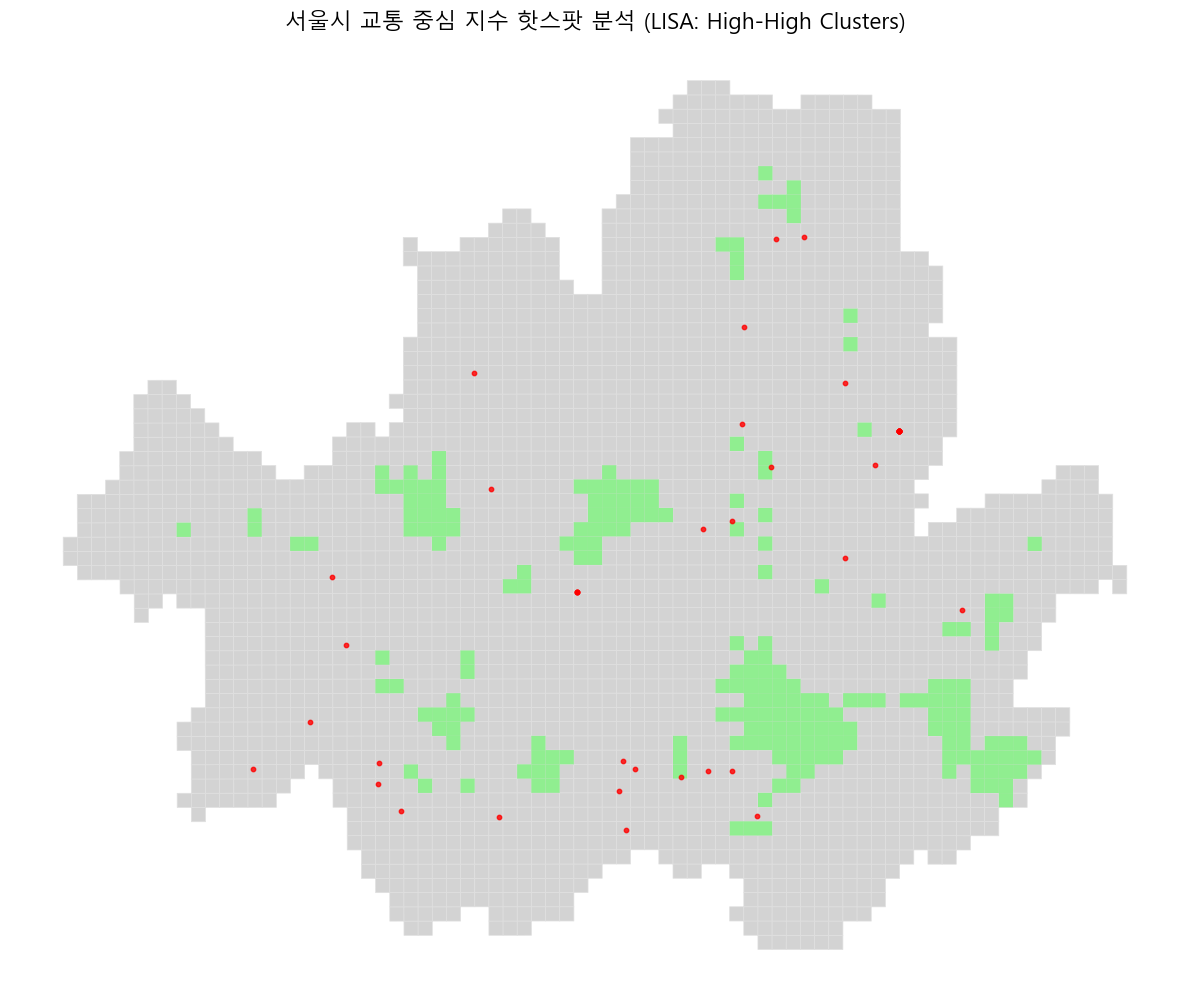

In [77]:
# 각 플롯에 넣기
# 먼저 교통! 

import matplotlib.pyplot as plt
import libpysal.weights
from esda.moran import Moran_Local

# --- 1. 공간 가중치 행렬(Spatial Weights Matrix) 생성 ---
# 각 격자가 어떤 다른 격자와 이웃인지를 정의하는 단계입니다.
# 'Queen' 방식은 모서리나 변을 공유하는 모든 이웃을 포함합니다.
print("공간 가중치 행렬을 생성합니다...")
wq = libpysal.weights.Queen.from_dataframe(geo_shp_final)
wq.transform = 'r' # 가중치를 행 표준화합니다.


# --- 2. LISA 분석 수행 ---
# 'total_trans' 열에 대해 Local Moran's I 통계량을 계산합니다.
print("LISA 분석을 수행하여 공간 클러스터를 찾습니다...")
lisa = Moran_Local(geo_shp_final['total_trans'], wq, seed=2025)


# --- 3. 유의미한 High-High 클러스터(핫스팟) 필터링 ---
# lisa.q는 클러스터의 종류를 나타냅니다: 1(HH), 2(LH), 3(LL), 4(HL)
# lisa.p_sim은 각 클러스터의 p-value(통계적 유의성)를 나타냅니다.

# 조건 1: High-High 클러스터일 것 (lisa.q == 1)
# 조건 2: 통계적으로 유의미할 것 (p-value < 0.05)
is_significant_hotspot = (lisa.q == 1) & (lisa.p_sim < 0.005)
hotspots_trans = geo_shp_final[is_significant_hotspot]

print(f"총 {len(geo_shp_final)}개 격자 중, 통계적으로 유의미한 핫스팟(High-High)은 {len(hotspots_trans)}개 입니다.")


points = gpd.GeoDataFrame(
    school_clean,
    geometry=[Point(xy) for xy in zip(school_clean["경도"], school_clean["위도"])],
    crs="EPSG:4326"
)

# --- 4. 시각화 ---
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# 4-1. [1단계] 배경 지도 그리기: 전체 격자를 연한 회색으로 표시합니다.
geo_shp_final.plot(
    ax=ax,
    color="lightgray",
    edgecolor="#e0e0e0",
    linewidth=0.5
)

# 4-2. [2단계] 핫스팟(High-High) 지역 덧그리기: 필터링된 핫스팟만 빨간색으로 강조합니다.
hotspots_trans.plot(
    ax=ax,
    color='lightgreen',          # 내부 색상을 빨간색으로 지정
#    edgecolor='black',    # 테두리 색상을 검은색으로
    linewidth=0.5
)
points.plot(ax=ax, color="red", markersize=10, alpha=0.8)

ax.set_title("서울시 교통 중심 지수 핫스팟 분석 (LISA: High-High Clusters)", fontsize=16)
ax.set_axis_off()

plt.tight_layout()
#plt.savefig('서울시 교통 중심 지수 + 유휴공간.png')
plt.show()


전체 42개의 유휴공간 중, 핫스팟 내부에 위치한 곳은 2개 입니다.


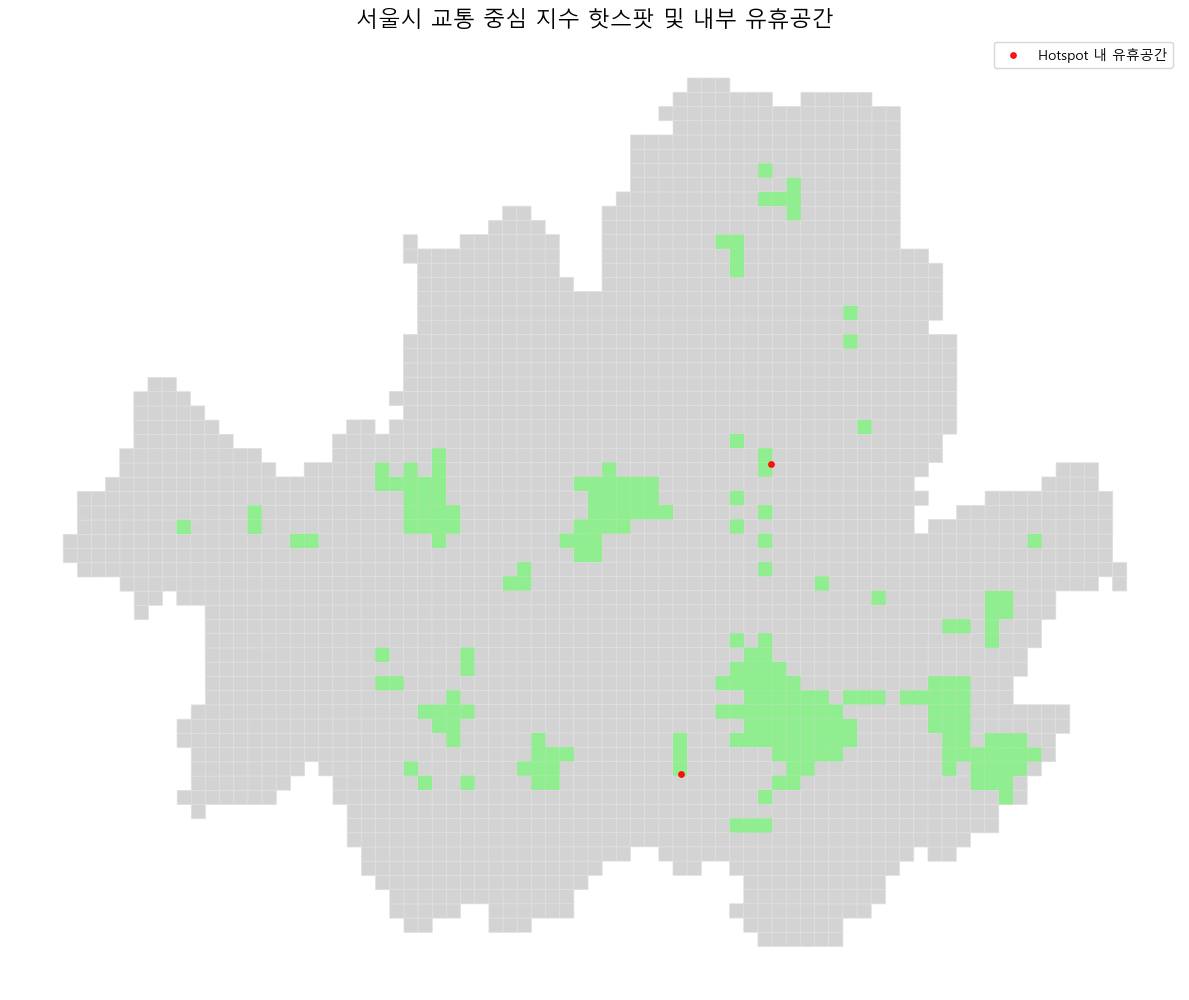

In [68]:
import geopandas as gpd # geopandas를 gpd로 불러왔다고 가정합니다.

# --- Hotspot과 겹치는 Point만 필터링 ---
# 'inner' join을 통해 points 중에서 hotspots 폴리곤 내에 있는(intersects) 것만 남깁니다.
points_in_hotspots = gpd.sjoin(points, hotspots, how="inner", predicate='intersects')

print(f"전체 {len(points)}개의 유휴공간 중, 핫스팟 내부에 위치한 곳은 {len(points_in_hotspots)}개 입니다.")


# --- 4. 시각화 ---
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# 4-1. 배경 지도 그리기
geo_shp_final.plot(ax=ax, color="lightgray", edgecolor="#e0e0e0", linewidth=0.5)

# 4-2. 핫스팟 지역 덧그리기
hotspots.plot(ax=ax, color='lightgreen', linewidth=0.5)

# 4-3. [수정] 전체 points 대신, 필터링된 points_in_hotspots를 지도에 표시합니다.
points_in_hotspots.plot(ax=ax, color="red", markersize=15, alpha=0.9, label='Hotspot 내 유휴공간')

ax.set_title("서울시 교통 중심 지수 핫스팟 및 내부 유휴공간", fontsize=16)
ax.set_axis_off()
ax.legend() # 범례 추가

plt.tight_layout()
#plt.savefig('서울시 수요 중심 지수 + 유휴공간_필터링.png')
plt.show()

In [69]:
points_in_hotspots.to_csv('교통중심_유휴시설.csv', encoding='cp949', index=False)

공간 가중치 행렬을 생성합니다...
LISA 분석을 수행하여 공간 클러스터를 찾습니다...


C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\1419969776.py:9: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = libpysal.weights.Queen.from_dataframe(geo_shp_final)


총 2639개 격자 중, 통계적으로 유의미한 핫스팟(High-High)은 341개 입니다.


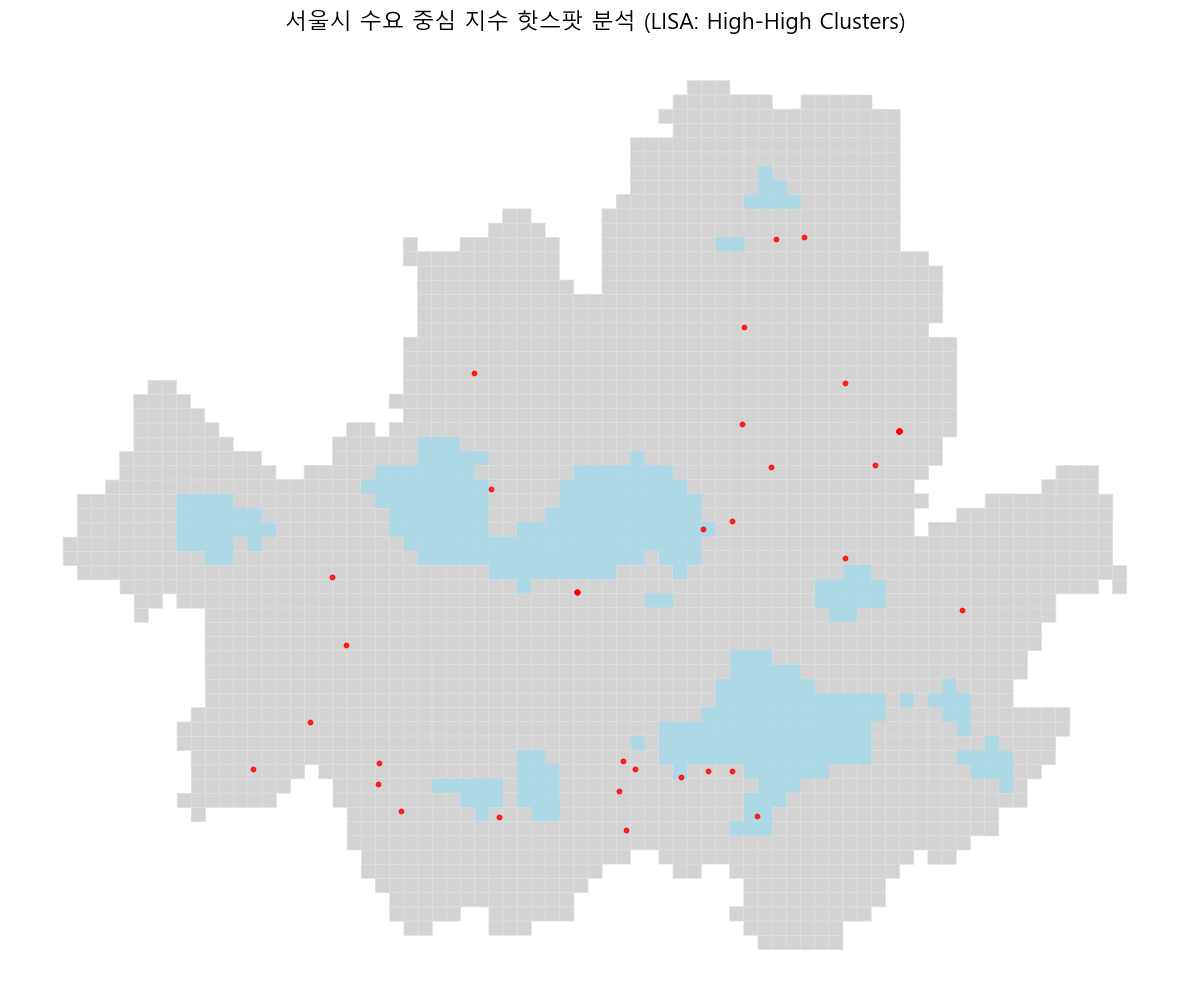

In [79]:
import matplotlib.pyplot as plt
import libpysal.weights
from esda.moran import Moran_Local

# --- 1. 공간 가중치 행렬(Spatial Weights Matrix) 생성 ---
# 각 격자가 어떤 다른 격자와 이웃인지를 정의하는 단계입니다.
# 'Queen' 방식은 모서리나 변을 공유하는 모든 이웃을 포함합니다.
print("공간 가중치 행렬을 생성합니다...")
wq = libpysal.weights.Queen.from_dataframe(geo_shp_final)
wq.transform = 'r' # 가중치를 행 표준화합니다.


# --- 2. LISA 분석 수행 ---
# 'total_trans' 열에 대해 Local Moran's I 통계량을 계산합니다.
print("LISA 분석을 수행하여 공간 클러스터를 찾습니다...")
lisa = Moran_Local(geo_shp_final['total_demm'], wq, seed=2025)


# --- 3. 유의미한 High-High 클러스터(핫스팟) 필터링 ---
# lisa.q는 클러스터의 종류를 나타냅니다: 1(HH), 2(LH), 3(LL), 4(HL)
# lisa.p_sim은 각 클러스터의 p-value(통계적 유의성)를 나타냅니다.

# 조건 1: High-High 클러스터일 것 (lisa.q == 1)
# 조건 2: 통계적으로 유의미할 것 (p-value < 0.05)
is_significant_hotspot = (lisa.q == 1) & (lisa.p_sim < 0.005)
hotspots_demm = geo_shp_final[is_significant_hotspot]

print(f"총 {len(geo_shp_final)}개 격자 중, 통계적으로 유의미한 핫스팟(High-High)은 {len(hotspots_demm)}개 입니다.")


points = gpd.GeoDataFrame(
    school_clean,
    geometry=[Point(xy) for xy in zip(school_clean["경도"], school_clean["위도"])],
    crs="EPSG:4326"
)

# --- 4. 시각화 ---
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# 4-1. [1단계] 배경 지도 그리기: 전체 격자를 연한 회색으로 표시합니다.
geo_shp_final.plot(
    ax=ax,
    color="lightgray",
    edgecolor="#e0e0e0",
    linewidth=0.5
)

# 4-2. [2단계] 핫스팟(High-High) 지역 덧그리기: 필터링된 핫스팟만 빨간색으로 강조합니다.
hotspots_demm.plot(
    ax=ax,
    color='lightblue',          # 내부 색상을 빨간색으로 지정
#    edgecolor='black',    # 테두리 색상을 검은색으로
    linewidth=0.5
)
points.plot(ax=ax, color="red", markersize=10, alpha=0.8)

ax.set_title("서울시 수요 중심 지수 핫스팟 분석 (LISA: High-High Clusters)", fontsize=16)
ax.set_axis_off()

plt.tight_layout()
#plt.savefig('서울시 수요 중심 지수 + 유휴공간.png')
plt.show()

전체 42개의 유휴공간 중, 핫스팟 내부에 위치한 곳은 3개 입니다.


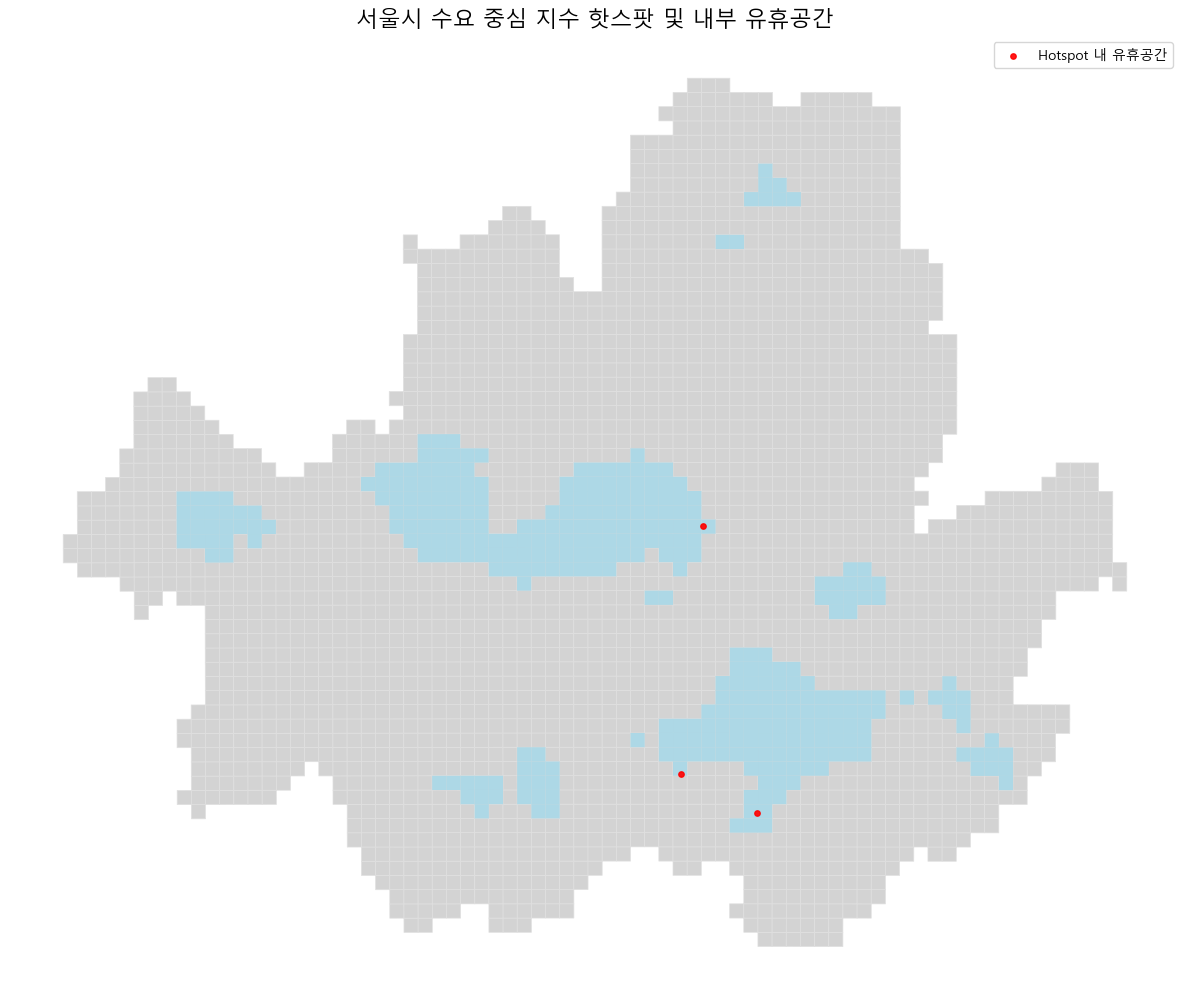

In [71]:
import geopandas as gpd # geopandas를 gpd로 불러왔다고 가정합니다.

# --- Hotspot과 겹치는 Point만 필터링 ---
# 'inner' join을 통해 points 중에서 hotspots 폴리곤 내에 있는(intersects) 것만 남깁니다.
points_in_hotspots = gpd.sjoin(points, hotspots, how="inner", predicate='intersects')

print(f"전체 {len(points)}개의 유휴공간 중, 핫스팟 내부에 위치한 곳은 {len(points_in_hotspots)}개 입니다.")


# --- 4. 시각화 ---
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# 4-1. 배경 지도 그리기
geo_shp_final.plot(ax=ax, color="lightgray", edgecolor="#e0e0e0", linewidth=0.5)

# 4-2. 핫스팟 지역 덧그리기
hotspots.plot(ax=ax, color='lightblue', linewidth=0.5)

# 4-3. [수정] 전체 points 대신, 필터링된 points_in_hotspots를 지도에 표시합니다.
points_in_hotspots.plot(ax=ax, color="red", markersize=15, alpha=0.9, label='Hotspot 내 유휴공간')

ax.set_title("서울시 수요 중심 지수 핫스팟 및 내부 유휴공간", fontsize=16)
ax.set_axis_off()
ax.legend() # 범례 추가

plt.tight_layout()
#plt.savefig('서울시 수요 중심 지수 + 유휴공간_필터링.png')
plt.show()

In [72]:
points_in_hotspots.to_csv('수요중심_유휴시설.csv', encoding='cp949', index=False)

In [88]:
pip install Platform

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement Platform (from versions: none)
ERROR: No matching distribution found for Platform


In [73]:
# 강남구 유휴공간 대관 센터 

공간 가중치 행렬을 생성합니다...
LISA 분석을 수행하여 공간 클러스터를 찾습니다...


C:\Users\Mycom\AppData\Local\Temp\ipykernel_22320\64381467.py:10: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = libpysal.weights.Queen.from_dataframe(geo_shp_final)


총 2639개 격자 중, 통계적으로 유의미한 핫스팟(High-High)은 270개 입니다.


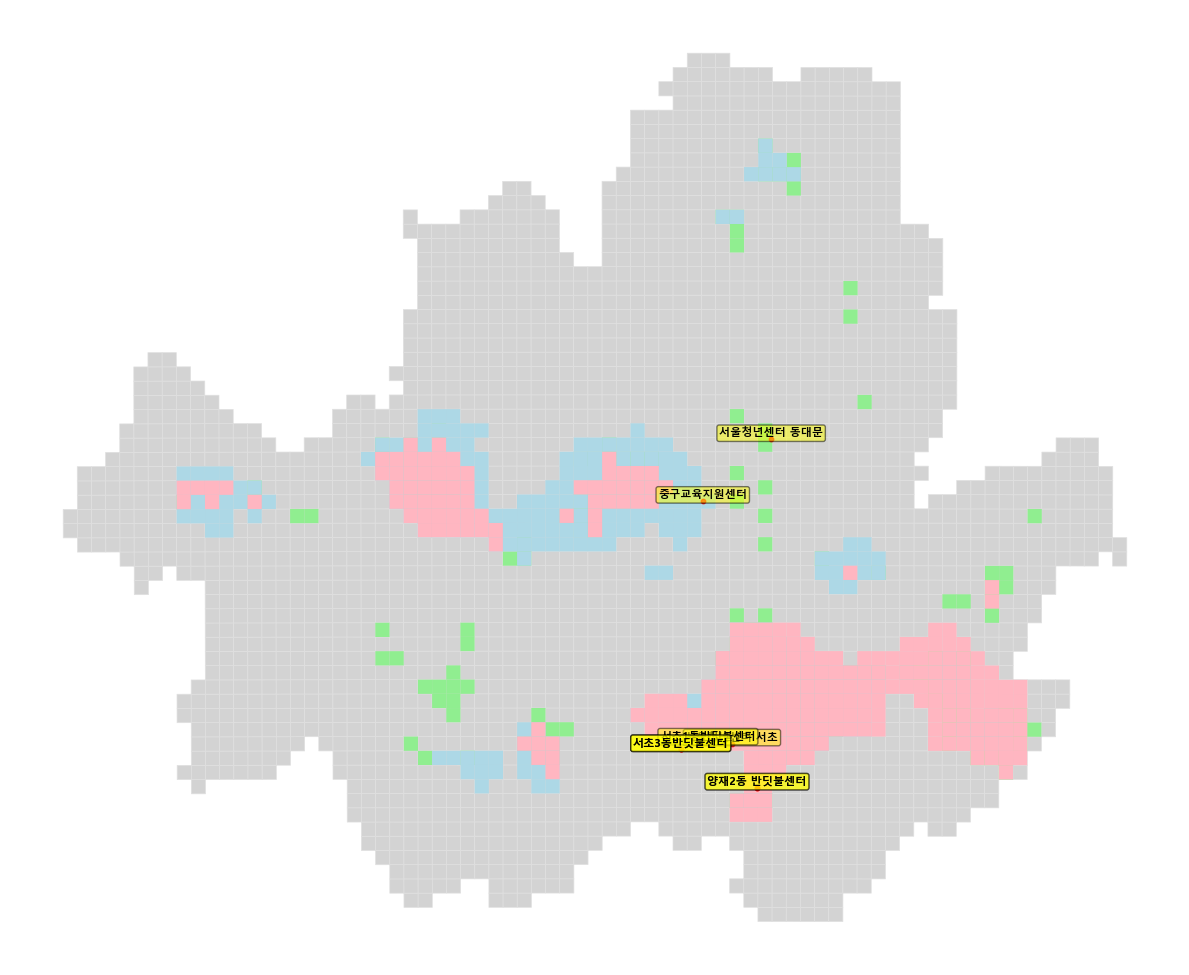

In [89]:
import matplotlib.pyplot as plt
import libpysal.weights
from esda.moran import Moran_Local
from adjustText import adjust_text  # adjustText 라이브러리 import

# --- [중요] 한글 폰트 설정 (코드 상단에 추가) ---
plt.rc('font', family='Malgun Gothic') # Windows 사용자
# plt.rc('font', family='AppleGothic') # Mac 사용자
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

# --- 1. 공간 가중치 행렬(Spatial Weights Matrix) 생성 ---
# 각 격자가 어떤 다른 격자와 이웃인지를 정의하는 단계입니다.
# 'Queen' 방식은 모서리나 변을 공유하는 모든 이웃을 포함합니다.
print("공간 가중치 행렬을 생성합니다...")
wq = libpysal.weights.Queen.from_dataframe(geo_shp_final)
wq.transform = 'r' # 가중치를 행 표준화합니다.


# --- 2. LISA 분석 수행 ---
# 'total_trans' 열에 대해 Local Moran's I 통계량을 계산합니다.
print("LISA 분석을 수행하여 공간 클러스터를 찾습니다...")
lisa = Moran_Local(geo_shp_final['total_comm'], wq, seed=2025)


# --- 3. 유의미한 High-High 클러스터(핫스팟) 필터링 ---
# lisa.q는 클러스터의 종류를 나타냅니다: 1(HH), 2(LH), 3(LL), 4(HL)
# lisa.p_sim은 각 클러스터의 p-value(통계적 유의성)를 나타냅니다.

# 조건 1: High-High 클러스터일 것 (lisa.q == 1)
# 조건 2: 통계적으로 유의미할 것 (p-value < 0.05)
is_significant_hotspot = (lisa.q == 1) & (lisa.p_sim < 0.005)
hotspots_comm = geo_shp_final[is_significant_hotspot]

print(f"총 {len(geo_shp_final)}개 격자 중, 통계적으로 유의미한 핫스팟(High-High)은 {len(hotspots_comm)}개 입니다.")


points = gpd.GeoDataFrame(
    school_clean,
    geometry=[Point(xy) for xy in zip(school_clean["경도"], school_clean["위도"])],
    crs="EPSG:4326"
)

# --- 4. 시각화 ---
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# 4-1. [1단계] 배경 지도 그리기: 전체 격자를 연한 회색으로 표시합니다.
geo_shp_final.plot(
    ax=ax,
    color="lightgray",
    edgecolor="#e0e0e0",
    linewidth=0.5
)

# 4-2. [2단계] 핫스팟(High-High) 지역 덧그리기: 필터링된 핫스팟만 빨간색으로 강조합니다.
hotspots_trans.plot(
    ax=ax,
    color='lightgreen',          # 내부 색상을 빨간색으로 지정
#    edgecolor='black',    # 테두리 색상을 검은색으로
    linewidth=0.5
)
hotspots_demm.plot(
    ax=ax,
    color='lightblue',          # 내부 색상을 빨간색으로 지정
#    edgecolor='black',    # 테두리 색상을 검은색으로
    linewidth=0.5
)
hotspots_comm.plot(
    ax=ax,
    color='lightpink',          # 내부 색상을 빨간색으로 지정
#    edgecolor='black',    # 테두리 색상을 검은색으로
    linewidth=0.5
)
points_in_hotspots_trans.plot(ax=ax, color="red", markersize=10, alpha=0.8)
points_in_hotspots_comm.plot(ax=ax, color="red", markersize=10, alpha=0.8)
points_in_hotspots_demm.plot(ax=ax, color="red", markersize=10, alpha=0.8)

def add_labels(points_gdf, ax, name_column):
    """점 GeoDataFrame에 대해 지도에 레이블을 추가하는 함수"""
    for idx, row in points_gdf.iterrows():
        # 레이블 텍스트와 좌표 가져오기
        label_text = row[name_column]
        x_coord = row.geometry.x
        y_coord = row.geometry.y
        
        # 텍스트 그리기
        ax.text(
            x_coord,
            y_coord,
            label_text,
            fontsize=8,          # 폰트 크기
            fontweight='bold',   # 폰트 두께
            color='black',       # 폰트 색상
            ha='center',         # 수평 정렬 (center, left, right)
            va='bottom',         # 수직 정렬 (bottom, top, center)
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5) # 텍스트 배경 상자
        )

# 각 점 데이터에 대해 레이블 추가 함수 호출
# 💡 '이름_컬럼명'을 실제 컬럼명으로 수정해주세요!
add_labels(points_in_hotspots_trans, ax, '이름') 
add_labels(points_in_hotspots_comm, ax, '이름')
add_labels(points_in_hotspots_demm, ax, '이름')
#ax.set_title("서울시 상권 중심 지수 핫스팟 분석 (LISA: High-High Clusters)", fontsize=16)
ax.set_axis_off()

plt.tight_layout()
#plt.savefig('서울시_특화_지수_point_label_추가.png', dpi=300) # 해상도 높여 저장
plt.show()

4 [0.16259829 0.81908538]
7 [0.6862045  0.55690352]
5 [ 0.16634397 -0.50900675]
8 [-0.88810873  0.56370938]


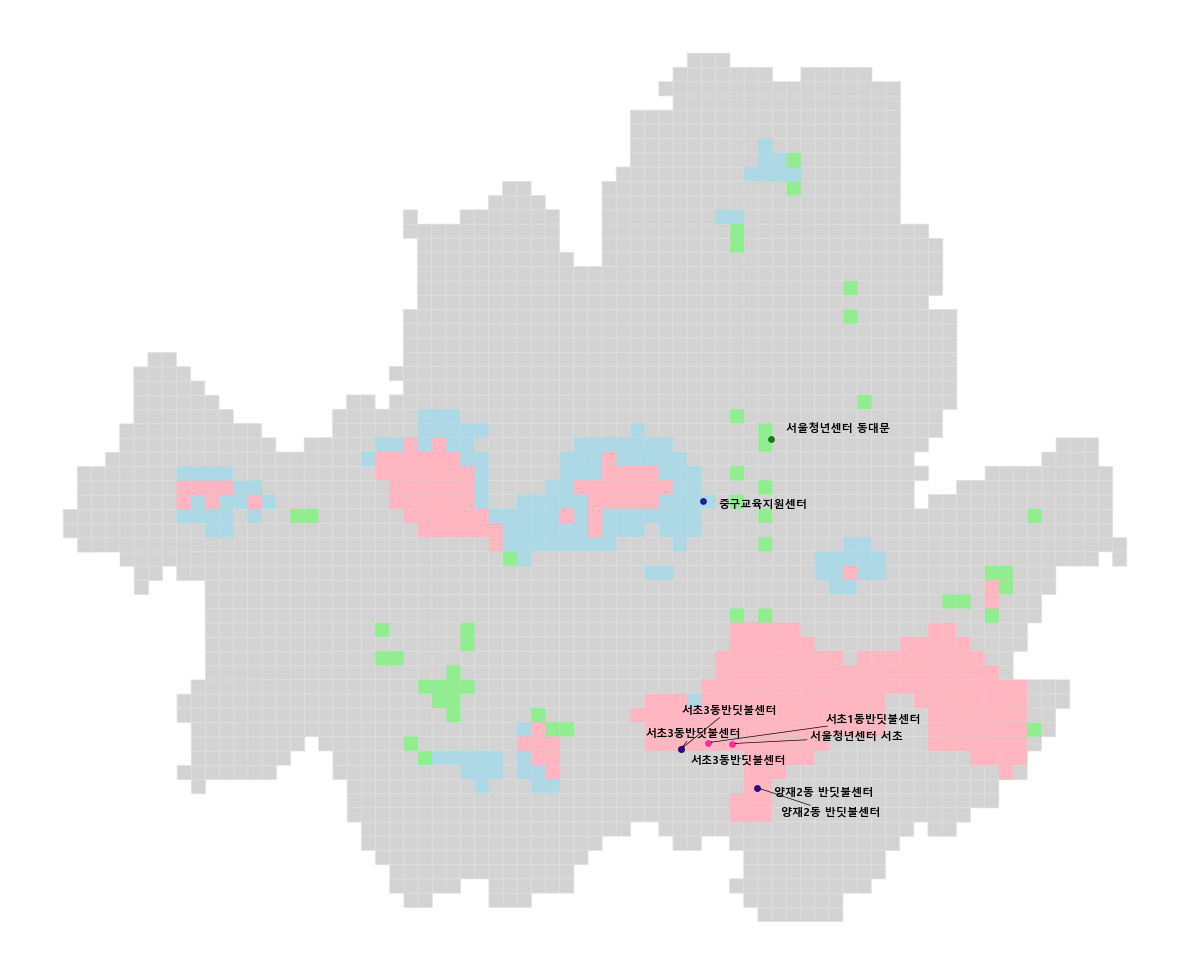

In [93]:
import matplotlib.pyplot as plt
import libpysal.weights
from esda.moran import Moran_Local
import geopandas as gpd
from shapely.geometry import Point
from adjustText import adjust_text  # adjustText 라이브러리 import

# --- [중요] 한글 폰트 설정 (코드 상단에 추가) ---
plt.rc('font', family='Malgun Gothic') # Windows 사용자
# plt.rc('font', family='AppleGothic') # Mac 사용자
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지


# --- 1, 2, 3 단계: 데이터 준비 (기존 코드와 동일) ---
# ... (geo_shp_final, hotspots_*, points_in_hotspots_* 등의 변수가 모두 준비되었다고 가정) ...


# --- 4. 시각화 ---
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# 4-1. 배경 지도 그리기
geo_shp_final.plot(ax=ax, color="lightgray", edgecolor="#e0e0e0", linewidth=0.5)

# 4-2. 핫스팟 지역 덧그리기
hotspots_trans.plot(ax=ax, color='lightgreen', linewidth=0.5)
hotspots_demm.plot(ax=ax, color='lightblue', linewidth=0.5)
hotspots_comm.plot(ax=ax, color='lightpink', linewidth=0.5)

# 4-3. 핫스팟 내의 점 덧그리기
points_in_hotspots_trans.plot(ax=ax, color="darkgreen", markersize=15, alpha=0.8)
points_in_hotspots_comm.plot(ax=ax, color="deeppink", markersize=15, alpha=0.8)
points_in_hotspots_demm.plot(ax=ax, color="darkblue", markersize=15, alpha=0.8)


# ----------------------------------------------------------------
# [핵심] 겹치지 않게 레이블 추가하기
# ----------------------------------------------------------------

# 1. 모든 레이블 텍스트 객체를 담을 빈 리스트 생성
texts = []

def create_labels(points_gdf, ax, name_column):
    """지도에 레이블을 추가하기 위한 텍스트 객체를 생성하여 리스트에 추가하는 함수"""
    for idx, row in points_gdf.iterrows():
        label_text = row[name_column]
        x_coord = row.geometry.x
        y_coord = row.geometry.y
        
        # ax.text()를 직접 그리지 않고, 생성된 text 객체를 texts 리스트에 추가
        texts.append(
            ax.text(
                x_coord, y_coord, label_text,
                fontsize=8,
                fontweight='bold',
                color='black'
            )
        )

# 각 점 데이터에 대해 레이블 객체 생성
create_labels(points_in_hotspots_trans, ax, '이름')
create_labels(points_in_hotspots_comm, ax, '이름')
create_labels(points_in_hotspots_demm, ax, '이름')


# 2. adjust_text를 호출하여 레이블 위치 자동 조정
# texts 리스트에 담긴 모든 레이블을 한 번에 처리합니다.
adjust_text(
    texts, 
    ax=ax,
    # 화살표 추가하여 점과 레이블 연결 (가독성 향상)
    arrowprops=dict(arrowstyle='->', color='black', lw=0.5)
)
# ----------------------------------------------------------------

ax.set_axis_off()
plt.tight_layout()
plt.savefig('서울시_특화_지수_레이블_조정.png', dpi=300)
plt.show()

In [83]:
points_in_hotspots_trans = gpd.sjoin(points, hotspots_trans, how="inner", predicate='intersects')
points_in_hotspots_comm = gpd.sjoin(points, hotspots_comm, how="inner", predicate='intersects')
points_in_hotspots_demm = gpd.sjoin(points, hotspots_demm, how="inner", predicate='intersects')

전체 42개의 유휴공간 중, 핫스팟 내부에 위치한 곳은 4개 입니다.


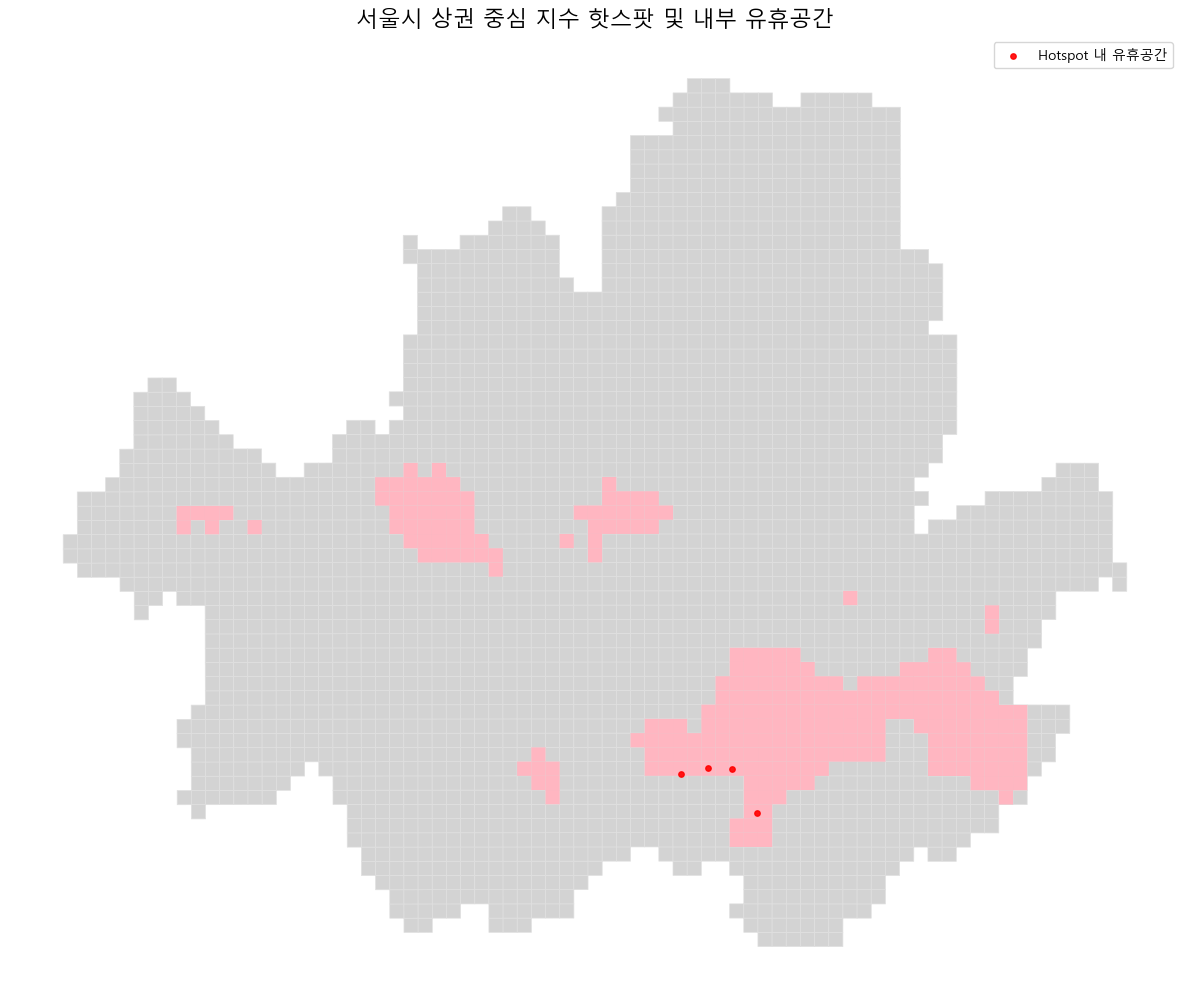

In [75]:
import geopandas as gpd # geopandas를 gpd로 불러왔다고 가정합니다.

# --- Hotspot과 겹치는 Point만 필터링 ---
# 'inner' join을 통해 points 중에서 hotspots 폴리곤 내에 있는(intersects) 것만 남깁니다.
points_in_hotspots = gpd.sjoin(points, hotspots, how="inner", predicate='intersects')

print(f"전체 {len(points)}개의 유휴공간 중, 핫스팟 내부에 위치한 곳은 {len(points_in_hotspots)}개 입니다.")


# --- 4. 시각화 ---
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# 4-1. 배경 지도 그리기
geo_shp_final.plot(ax=ax, color="lightgray", edgecolor="#e0e0e0", linewidth=0.5)

# 4-2. 핫스팟 지역 덧그리기
hotspots.plot(ax=ax, color='lightpink', linewidth=0.5)

# 4-3. [수정] 전체 points 대신, 필터링된 points_in_hotspots를 지도에 표시합니다.
points_in_hotspots.plot(ax=ax, color="red", markersize=15, alpha=0.9, label='Hotspot 내 유휴공간')

ax.set_title("서울시 상권 중심 지수 핫스팟 및 내부 유휴공간", fontsize=16)
ax.set_axis_off()
ax.legend() # 범례 추가

plt.tight_layout()
#plt.savefig('서울시 수요 중심 지수 + 유휴공간_필터링.png')
plt.show()

In [76]:
points_in_hotspots.to_csv('상권중심_유휴시설.csv', encoding='cp949', index=False)